In [2]:
import sys
sys.path.append('/share/jccrews/tumor-seg/mamba-tumor-seg/models')
print(sys.path)

['/share/jccrews/tumor-seg/mamba-tumor-seg/tests', '/share/jccrews/miniconda3/envs/umamba/lib/python310.zip', '/share/jccrews/miniconda3/envs/umamba/lib/python3.10', '/share/jccrews/miniconda3/envs/umamba/lib/python3.10/lib-dynload', '', '/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages', '/share/jccrews/U-Mamba/U-Mamba/umamba', '/share/jccrews/tumor-seg/mamba-tumor-seg/models']


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

from dice_loss import DiceLoss
import torch.optim as optim
from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset

from transforms import BrainMRITransforms

from BCEDiceLoss import BceDiceLoss

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score

from UMambaBot_pp import load_model_and_weights as load_UMambaBot_pp
from UMambaBot import load_model_and_weights as load_UMambaBot
from UNet import load_model_and_weights as load_unet
from ResNet18 import load_model_and_weights as load_resnet18
from ResNet50 import load_model_and_weights as  load_resnet50
from ultralightVMUNet import load_model_and_weights as load_ultralightVMUNet
from ultralightVMUNet_v1 import load_model_and_weights as load_ultralightVMUNet_v1
from ultralightVMUNet_v2 import load_model_and_weights as load_ultralightVMUNet_v2
from ultralightVMUNet_v3 import load_model_and_weights as load_ultralightVMUNet_v3
from ultralightVMUNet_v4 import load_model_and_weights as load_ultralightVMUNet_v4
from ultralightVMUNet_v5 import load_model_and_weights as load_ultralightVMUNet_v5
from segformer import load_data_model_and_weights as load_data_and_segformer



/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# batch
batch_size = 16

learning_rate = 0.0003

In [6]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

transform_ = BrainMRITransforms()

train_data = BrainMRIDataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = BrainMRIDataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = BrainMRIDataset(test_df, transform = transform_ ,  mask_transform= transform_)

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = False)


In [11]:
print(len(train_df))
print(len(train_data))

3143
3143


In [7]:
## Initialize models 

UMambaBot_pp = load_UMambaBot_pp(device)
UMambaBot = load_UMambaBot(device)
ResNet18 = load_resnet18(device)
ResNet50 = load_resnet50(device)
UNet = load_unet(device)
UltraLight_VM_UNet = load_ultralightVMUNet(device)
UltraLight_VM_UNet_v1 = load_ultralightVMUNet_v1(device)
UltraLight_VM_UNet_v2 = load_ultralightVMUNet_v2(device)
UltraLight_VM_UNet_v3 = load_ultralightVMUNet_v3(device)
UltraLight_VM_UNet_v4 = load_ultralightVMUNet_v4(device)
UltraLight_VM_UNet_v5 = load_ultralightVMUNet_v5(device)


# Load segformer model and weights
SegFormer, segformer_train_dataloader, segformer_val_dataloader, segformer_test_dataloader = load_data_and_segformer(train_df, val_df, test_df)





SC_Att_Bridge was used
SC_Att_Bridge was used
SC_Att_Bridge was used
SC_Att_Bridge was used
SC_Att_Bridge was used
SC_Att_Bridge was used


In [8]:
# def visualize_sample(image, true_mask, pred_masks, image_titles, pred_mask_titles, v_iou, v_dice):
#     num_models = len(pred_masks)
#     num_cols = num_models + 1  # Add one column for the true mask
#     fig, axes = plt.subplots(2, num_cols, figsize=(5*num_cols, 10))

#     # Plot image
#     for i in range(num_cols):
#         axes[0, i].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
#         axes[0, i].set_title(image_titles[i], fontweight='bold')
#         axes[0, i].axis('off')

#     # Plot true mask
#     axes[1, 0].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')
#     axes[1, 0].set_title('True Mask', fontweight='bold')
#     axes[1, 0].axis('off')

#     # Plot predicted masks
#     for i in range(num_models):
#         axes[1, i+1].imshow(pred_masks[i].squeeze().cpu().numpy(), cmap='gray')
#         axes[1, i+1].set_title(f'{pred_mask_titles[i]} Mask', fontweight='bold')
#         axes[1, i+1].axis('off')

#         specific_image_ax = axes[1, i+1]
#         specific_image_ax.text(0.5, -0.05, f'IOU: {v_iou[i]:.4f}, Dice: {v_dice[i]:.4f}', 
#                                horizontalalignment='center', verticalalignment='center', 
#                                transform=specific_image_ax.transAxes, fontsize=10)
#     plt.show()

## New configuration of images
from math import ceil
def visualize_sample(image, true_mask, pred_masks, image_titles, pred_mask_titles, v_iou, v_dice):
    num_models = len(pred_masks)
    half_models = ceil(num_models/2)
    num_cols = half_models + 1
    fig, axes = plt.subplots(2, num_cols, figsize=(4*num_cols, 8))

    # Plot input image
    axes[0, 0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0, 0].set_title('Input Image', fontweight='bold')
    axes[0, 0].axis('off')

    # Plot true mask
    axes[1, 0].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 0].set_title('True Mask', fontweight='bold')
    axes[1, 0].axis('off')

    # Plot predicted masks
    for i in range(0, half_models):
        axes[0, i+1].imshow(pred_masks[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i+1].set_title(f'{pred_mask_titles[i]} Mask', fontweight='bold')
        axes[0, i+1].axis('off')

        specific_image_ax = axes[0, i+1]
        specific_image_ax.text(0.5, -0.05, f'IOU: {v_iou[i]:.4f}, Dice: {v_dice[i]:.4f}', 
                               horizontalalignment='center', verticalalignment='center', 
                               transform=specific_image_ax.transAxes, fontsize=10)
        
    # Plot predicted masks
    for i in range(half_models, num_models):
        idx = i-(half_models-1)
        axes[1, idx].imshow(pred_masks[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, idx].set_title(f'{pred_mask_titles[i]} Mask', fontweight='bold')
        axes[1, idx].axis('off')

        specific_image_ax = axes[1, idx]
        specific_image_ax.text(0.5, -0.05, f'IOU: {v_iou[i]:.4f}, Dice: {v_dice[i]:.4f}', 
                               horizontalalignment='center', verticalalignment='center', 
                               transform=specific_image_ax.transAxes, fontsize=10)
    plt.show()



In [9]:
def eval_models(models, pred_mask_titles, image_titles):
    # Initialize lists to store total IOU and Dice scores for each model
    num_models = len(models)
    total_iou = [0] * num_models
    total_dice_score = [0] * num_models

    ct = 0
    

    with torch.no_grad():
        for (imgs, labels), (sf_imgs, sf_labels) in zip(test_dataloader, segformer_test_dataloader):
            imgs, labels = imgs.to(device).float(), labels.to(device).float()
            sf_imgs, sf_labels = sf_imgs.to(device).float(), sf_labels.to(device).float()

            # Make predictions for each model
            preds = []
            for model in models:
                if (model == SegFormer):
                    # Segformer model predictions
                    pred = SegFormer(sf_imgs)
                    pred = nn.functional.interpolate(pred, size=sf_labels.shape[-2:], mode="bilinear", align_corners=False)
                    pred = (torch.sigmoid(pred) >= 0.5).to(torch.float32)
                    preds.append(pred)
                else:    
                    pred = model(imgs)
                    pred = torch.where(pred >= 0.5, 1., 0.)
                    preds.append(pred)
                
            prt_ct = 0
            # Visualize the sample and calculate IOU and Dice scores for the first batch
            # if ct <= len(test_dataloader):
            if ct == 14 or ct == 22 or ct == 13 or ct == 19 or ct == 0 or ct == 12:
                for k in range(len(imgs)):
                    
                    display_imgs = False
                    for i in range(num_models):
                        if torch.sum(preds[i][k]) > 0:
                            display_imgs = True
                            break

                    if display_imgs and prt_ct <= 2:
                        prt_ct += 1
                        print(f'Batch {ct}, Image {k}')

                        v_preds = []
                        for i in range(len(preds)):
                            v_preds.append(preds[i][k])

                        v_iou = []
                        v_dice = []
                        for i in range(num_models):
                            if (models[i] == SegFormer):
                                iou = calculate_iou(preds[i][k], sf_labels[k])
                                dice_score = calculate_dice_score(preds[i][k], sf_labels[k])
                                v_iou.append(iou)
                                v_dice.append(dice_score)
                            else:
                                iou = calculate_iou(preds[i][k], labels[k])
                                dice_score = calculate_dice_score(preds[i][k], labels[k])
                                v_iou.append(iou)
                                v_dice.append(dice_score)

                        visualize_sample(imgs[k], labels[k], v_preds, image_titles, pred_mask_titles, v_iou, v_dice)

            ct += 1

            # Calculate total IOU and Dice scores for each model
            for i in range(num_models):
                if (models[i] == SegFormer):
                    total_iou[i] += calculate_iou(preds[i], sf_labels)
                    total_dice_score[i] += calculate_dice_score(preds[i], sf_labels)
                else: 
                    total_iou[i] += calculate_iou(preds[i], labels)
                    total_dice_score[i] += calculate_dice_score(preds[i], labels)

    # Calculate average IOU and Dice scores for each model
    test_iou = [iou / len(test_dataloader) for iou in total_iou]
    test_dice_score = [dice / len(test_dataloader) for dice in total_dice_score]

    # Print average IOU and Dice scores for each model
    for i in range(num_models):
        print(f'{pred_mask_titles[i]}_IOU: {test_iou[i]}')
        print(f'{pred_mask_titles[i]}_dice_score: {test_dice_score[i]}')

Batch 0, Image 0


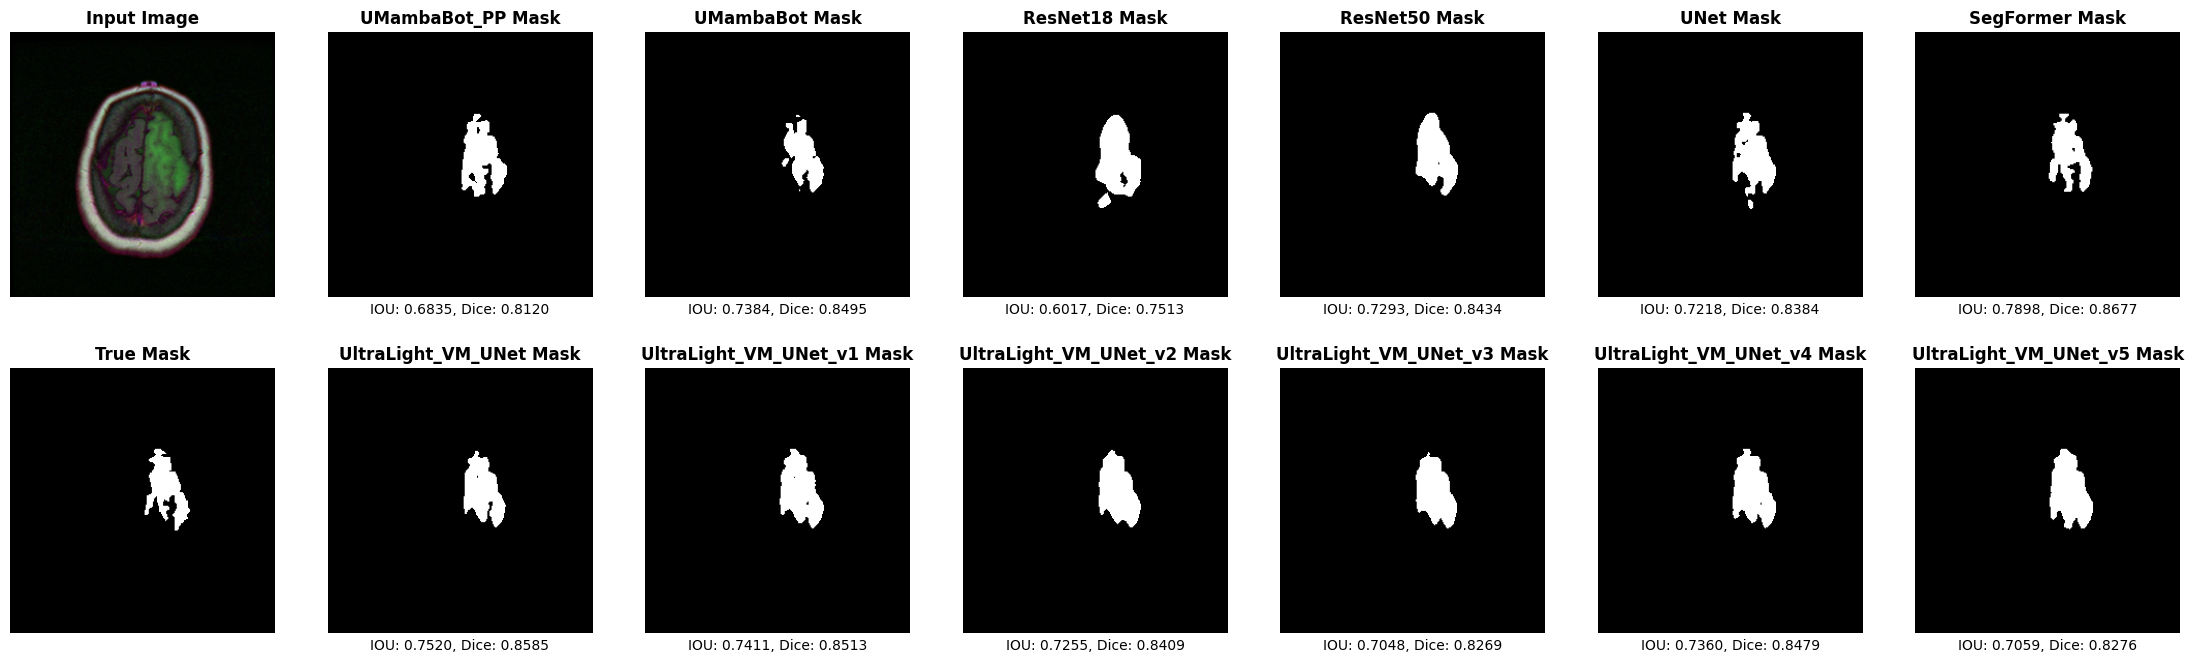

Batch 0, Image 3


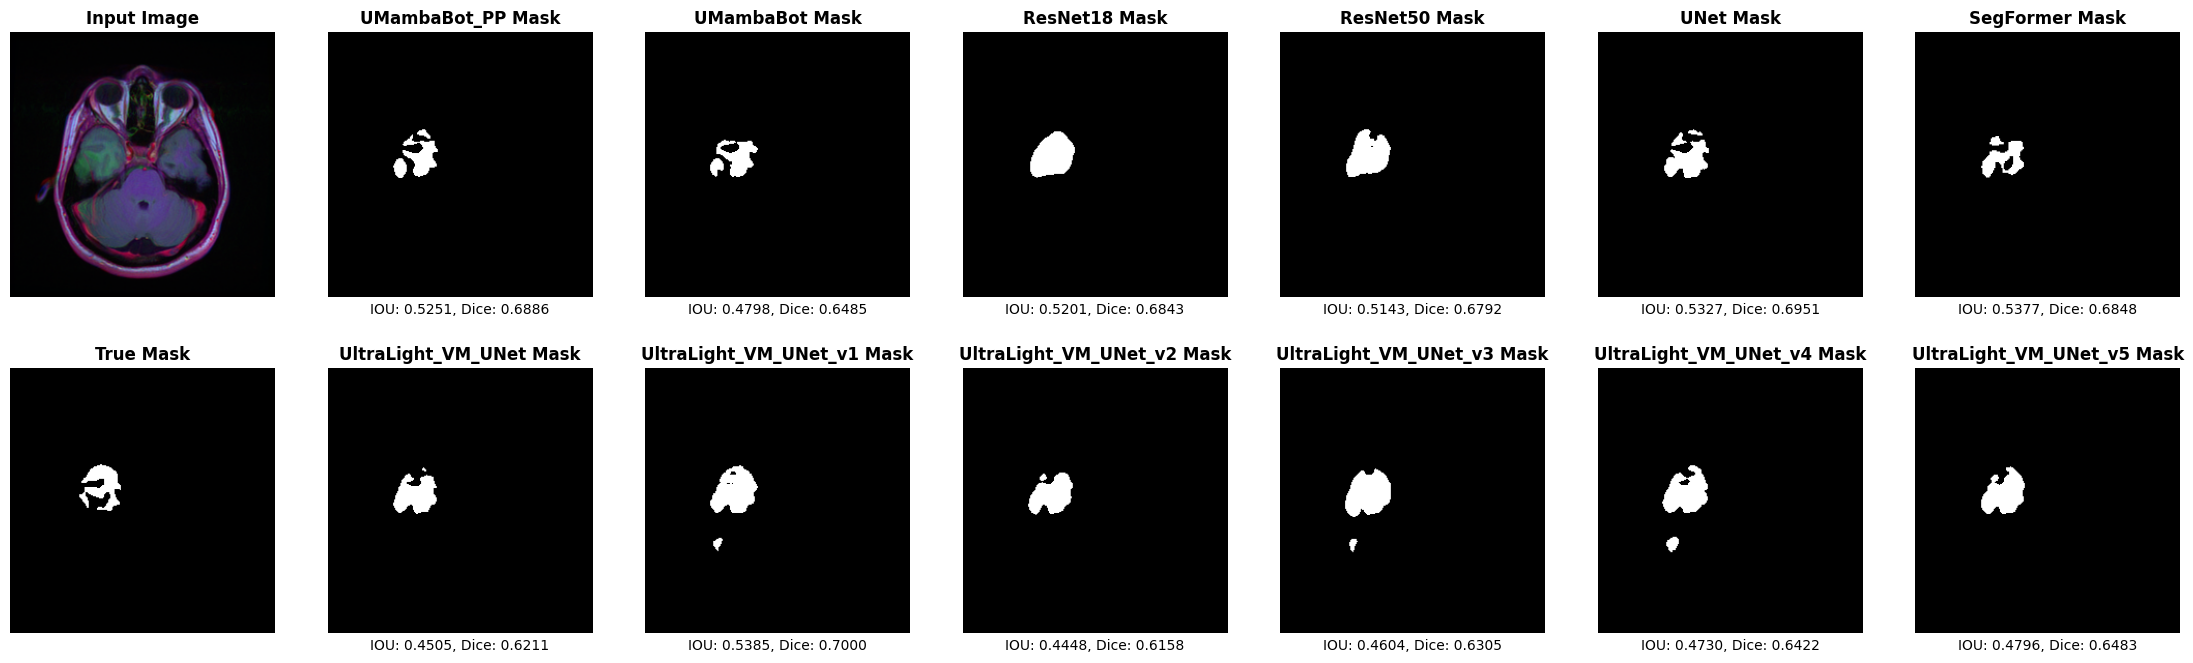

Batch 0, Image 6


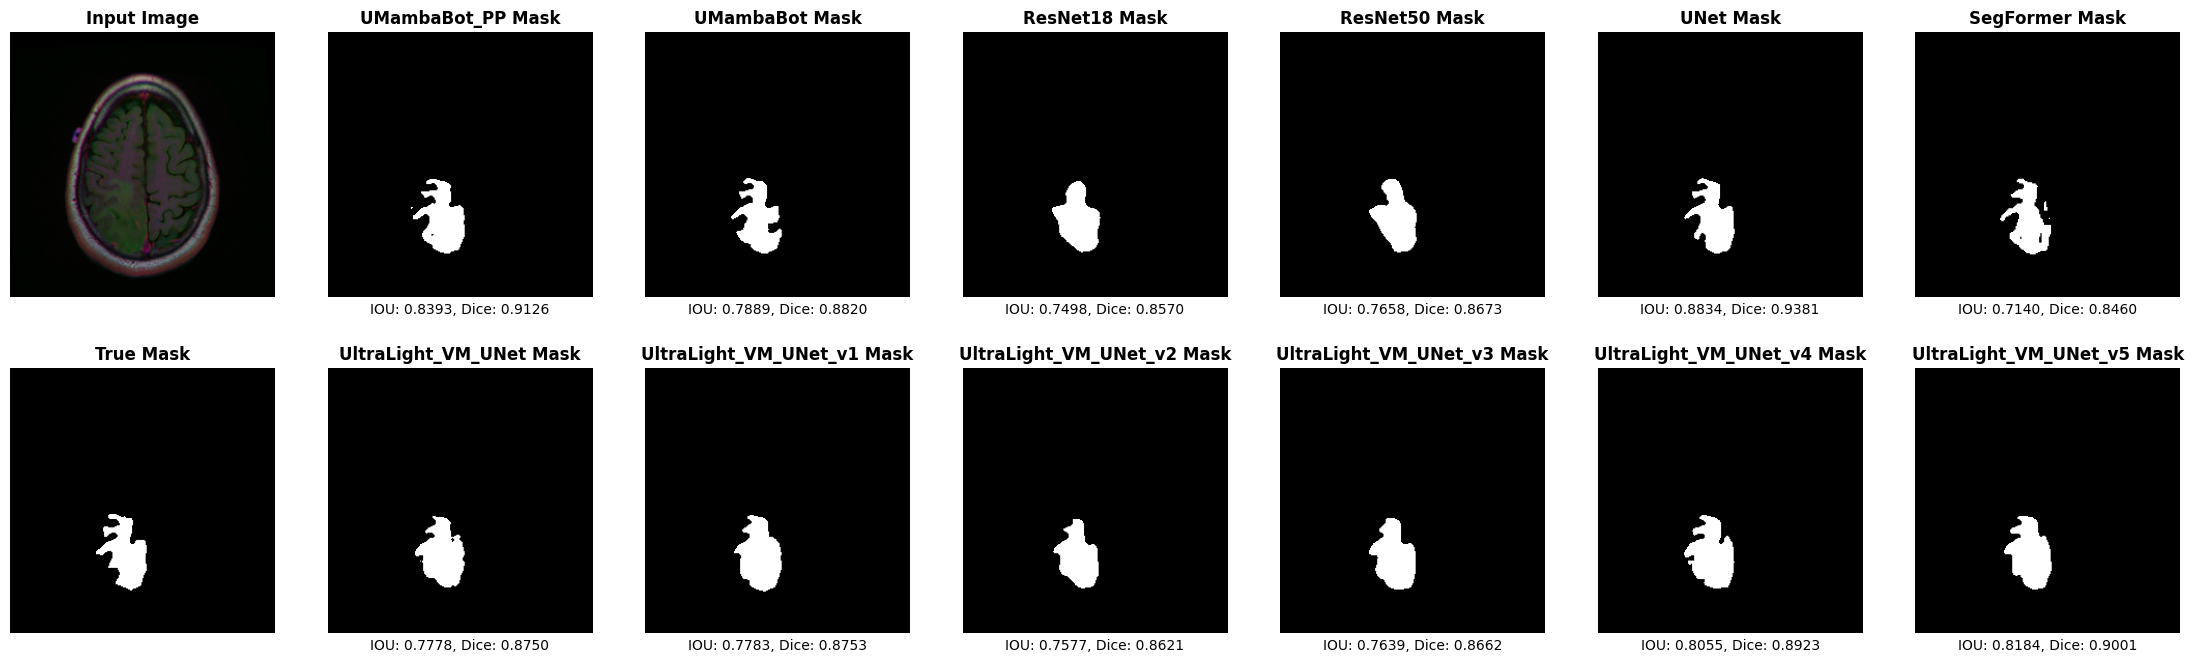

Batch 12, Image 0


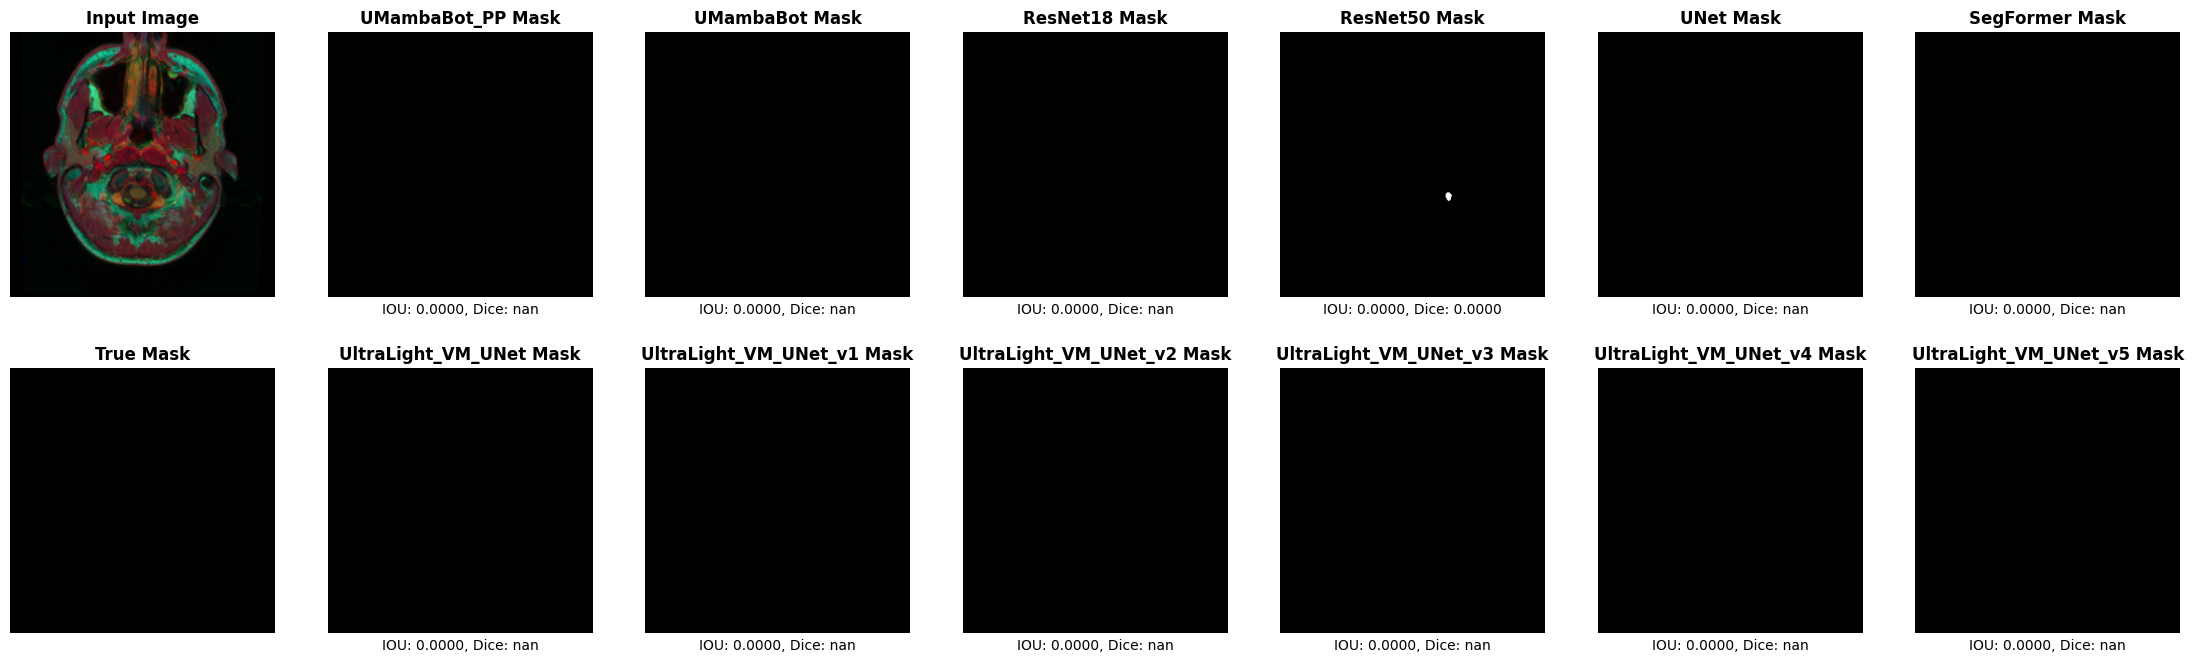

Batch 12, Image 2


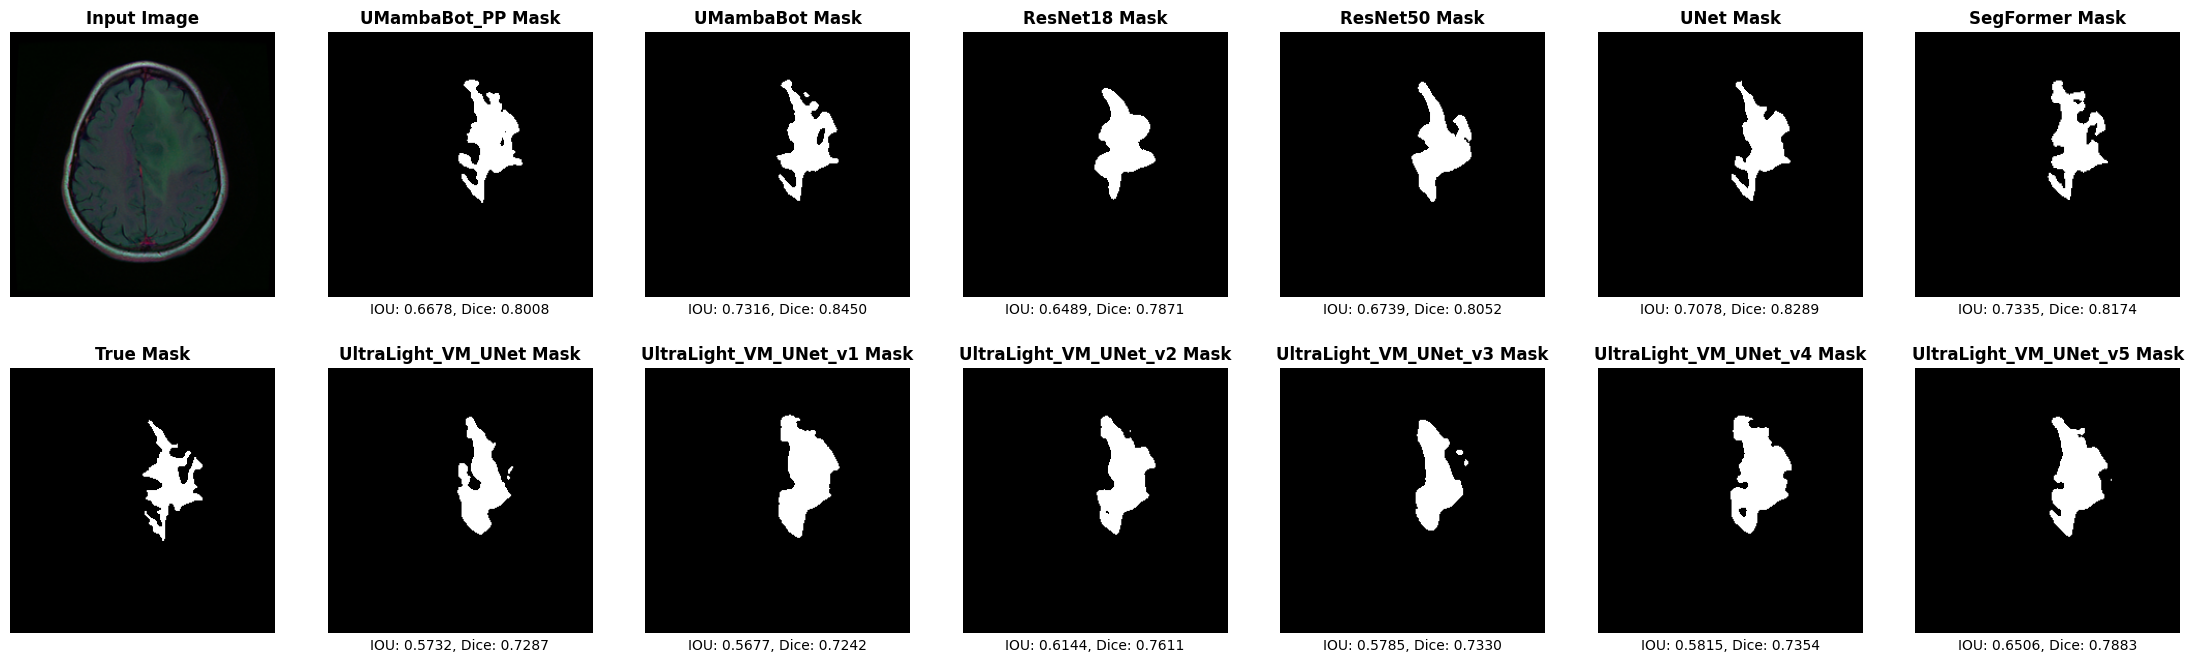

Batch 12, Image 3


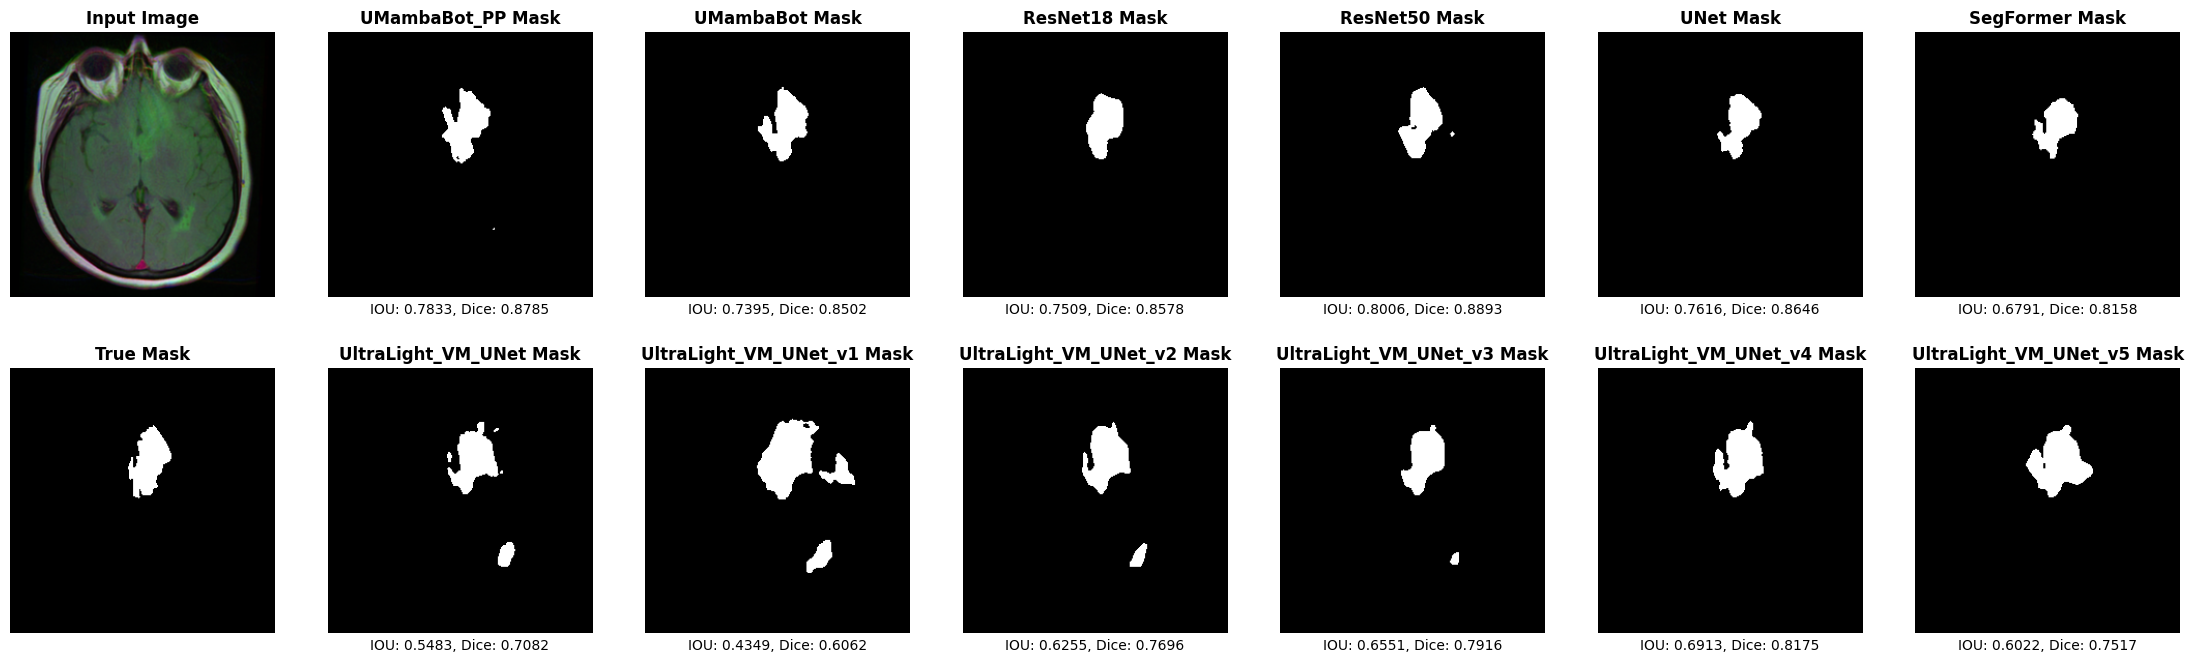

Batch 13, Image 1


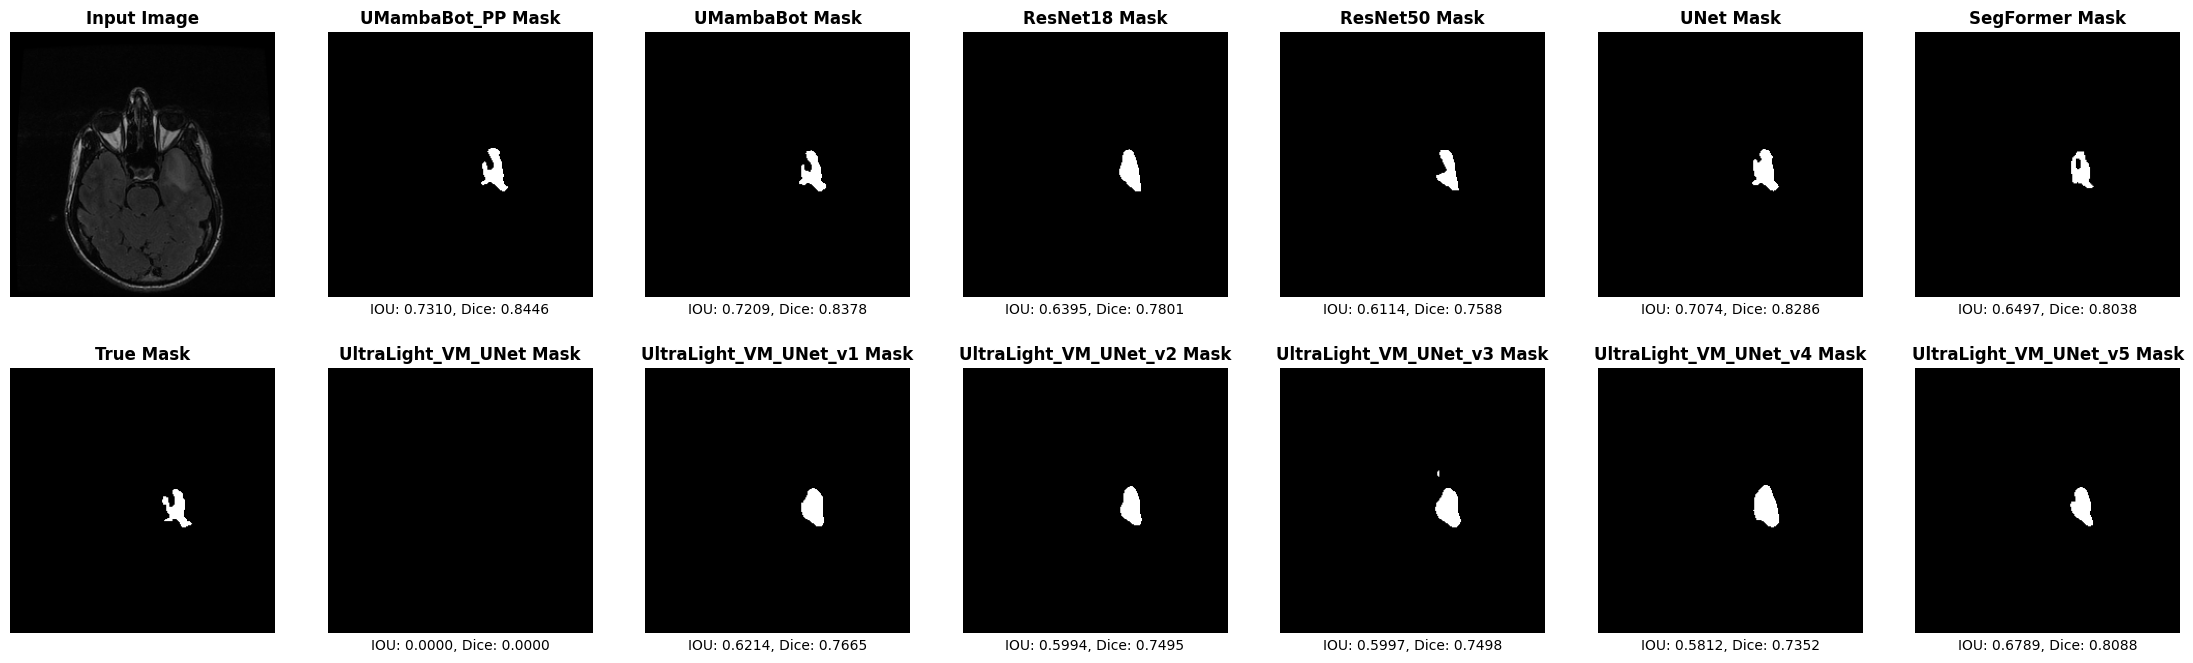

Batch 13, Image 3


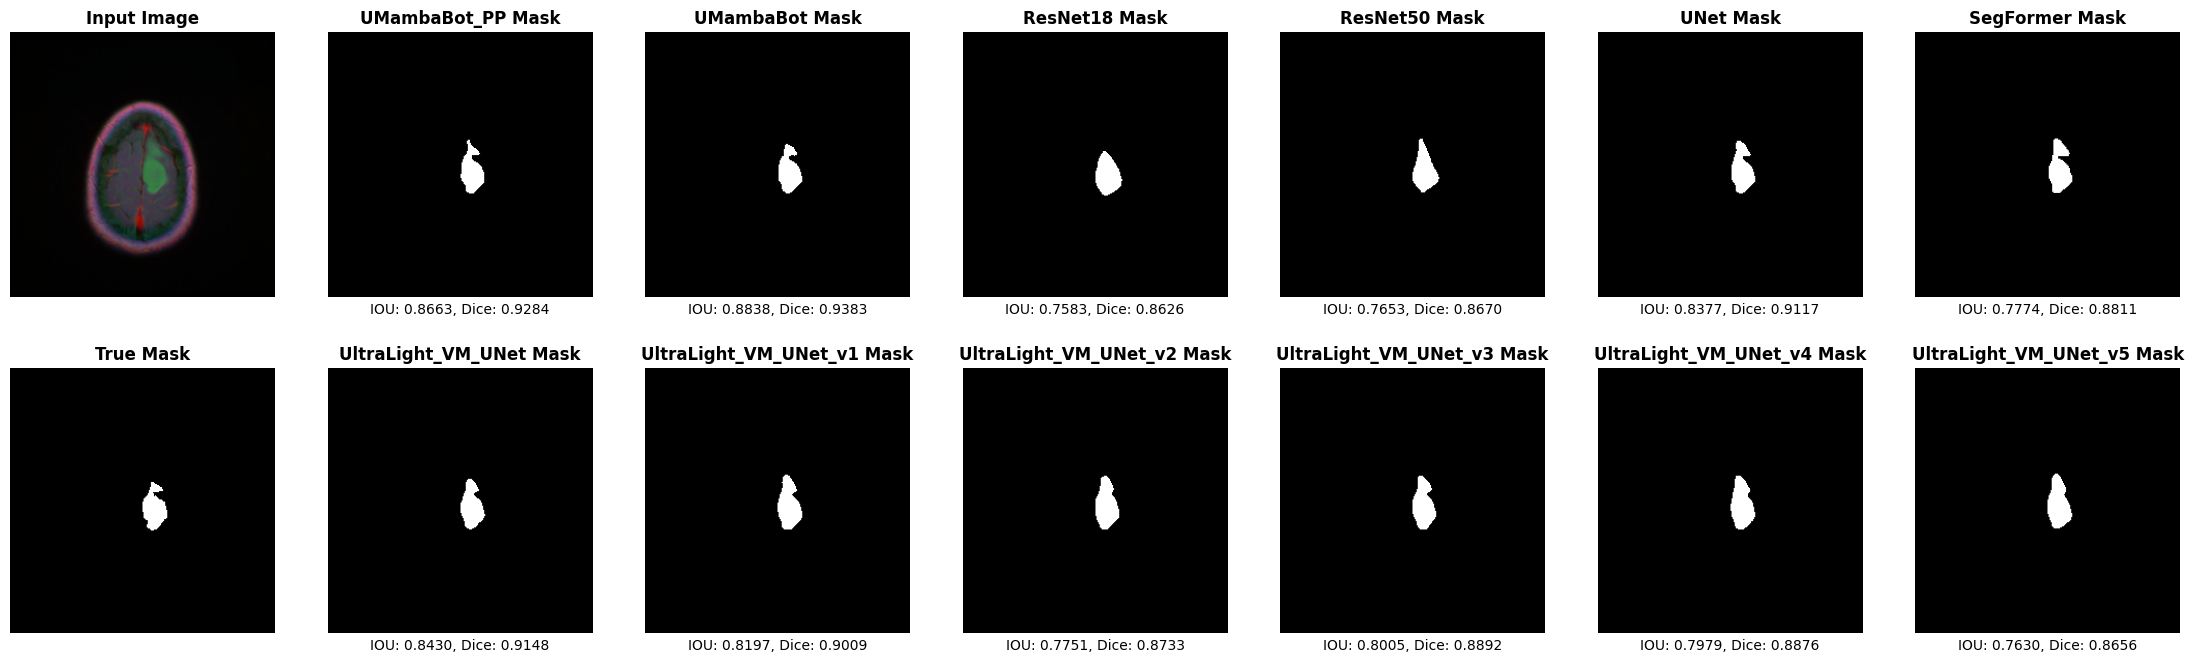

Batch 13, Image 4


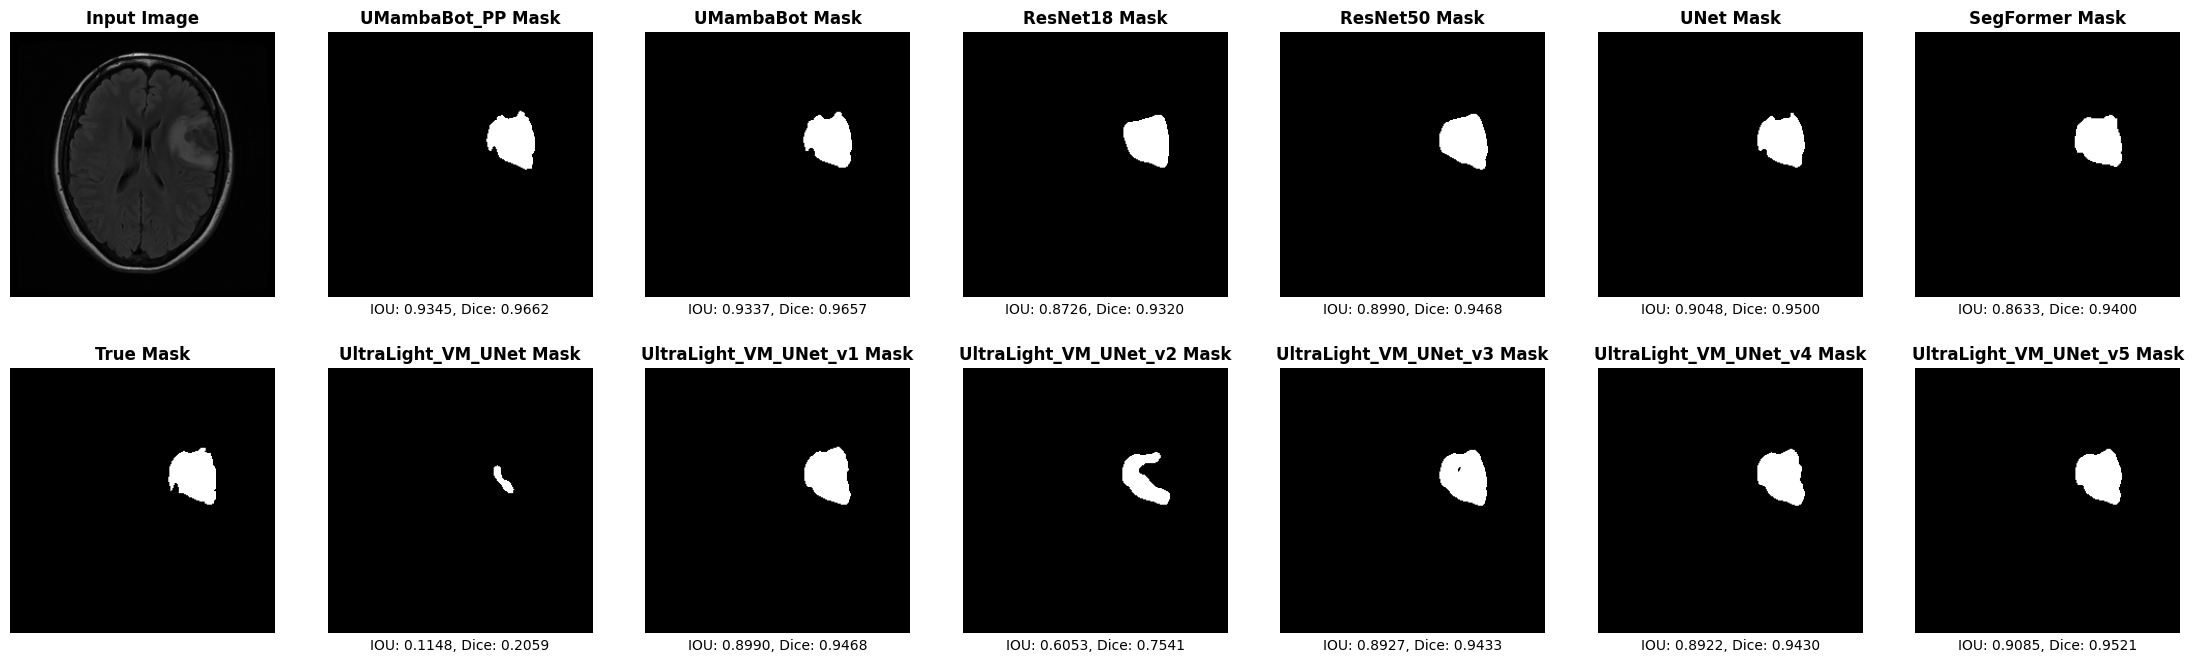

Batch 14, Image 3


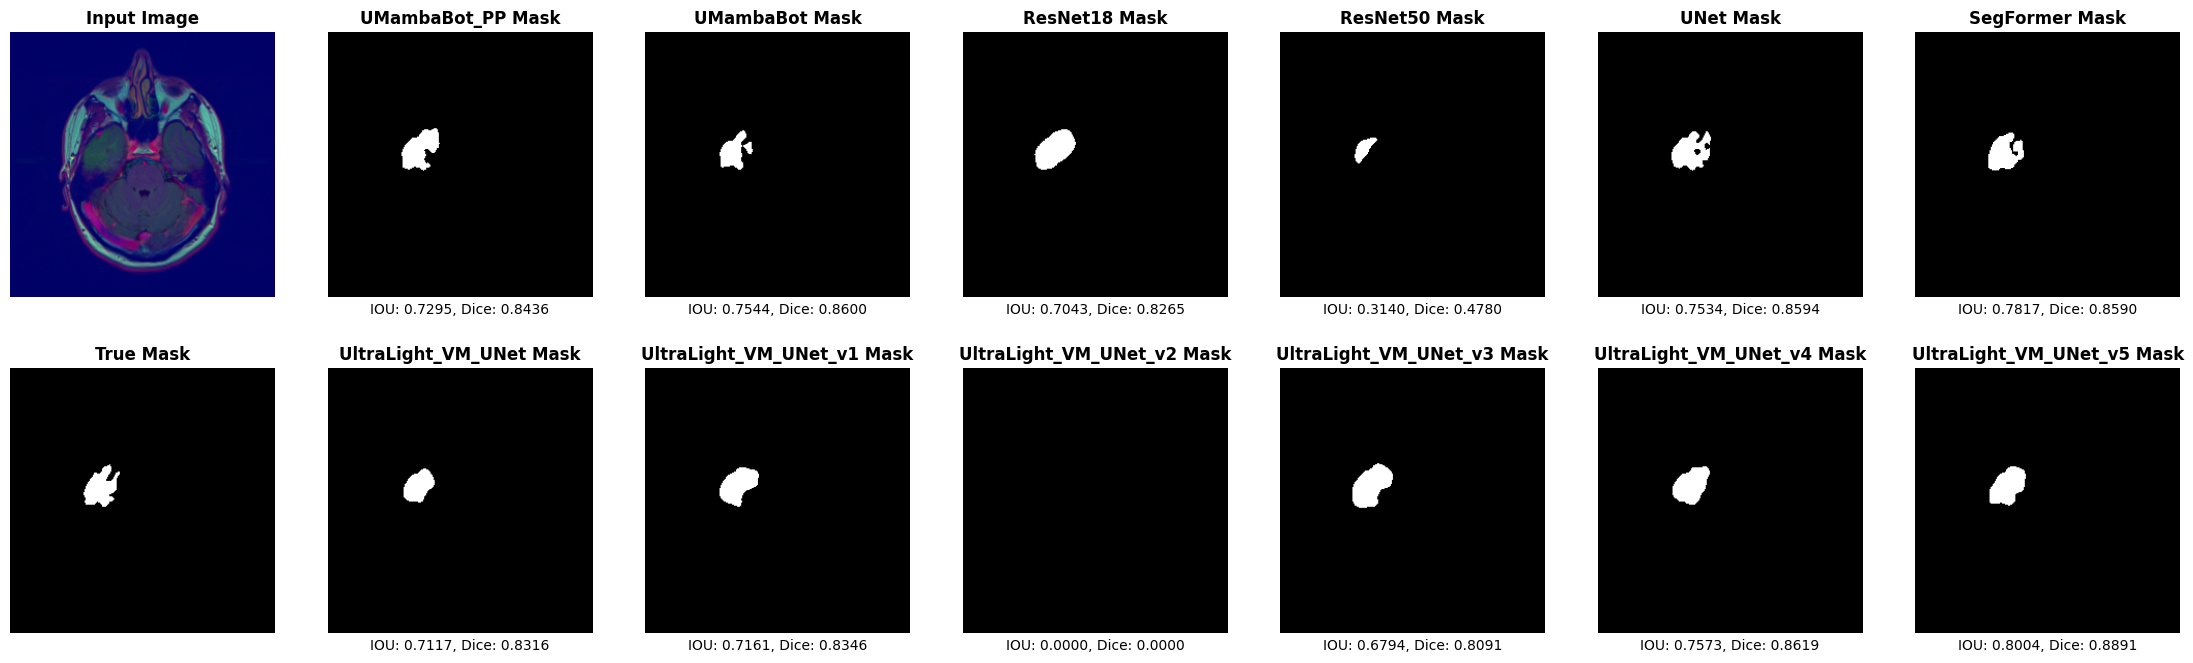

Batch 14, Image 9


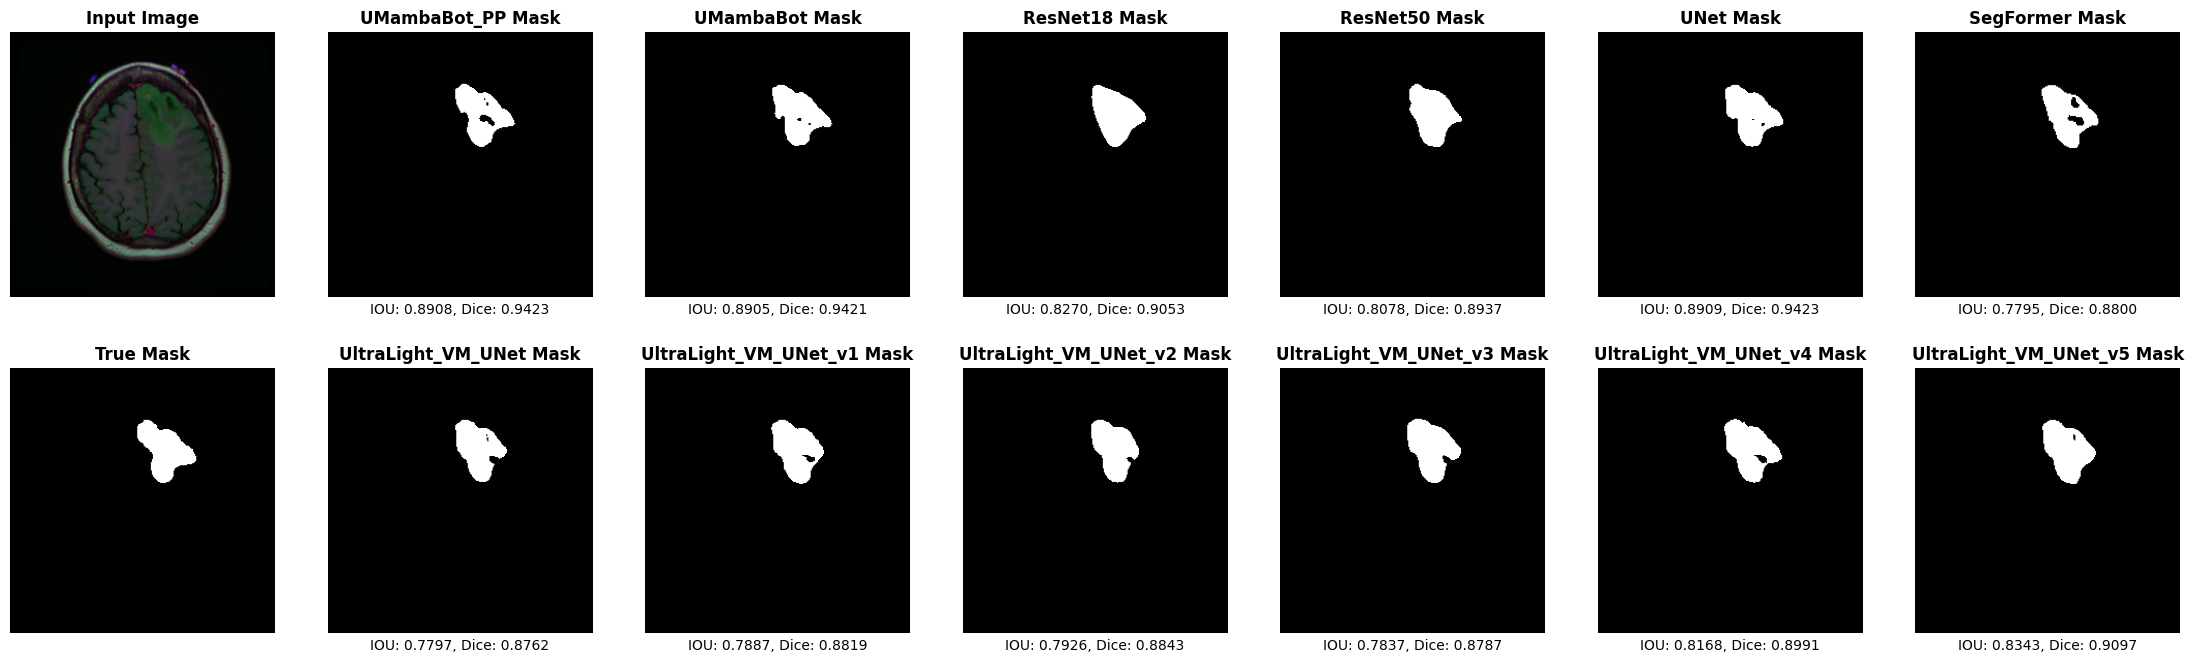

Batch 14, Image 13


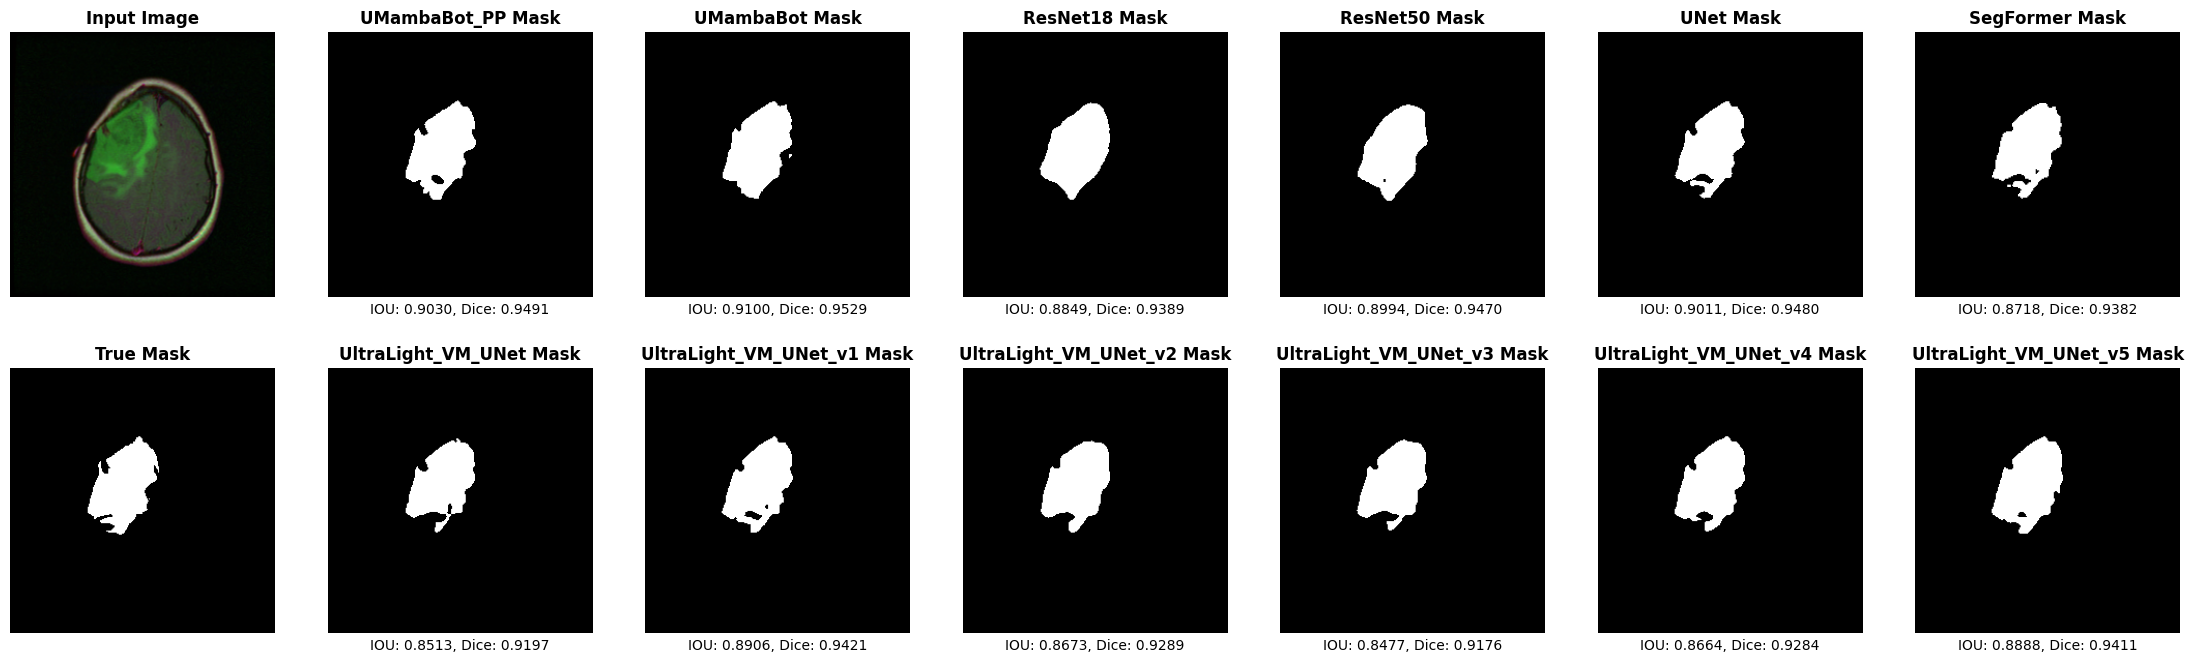

Batch 19, Image 0


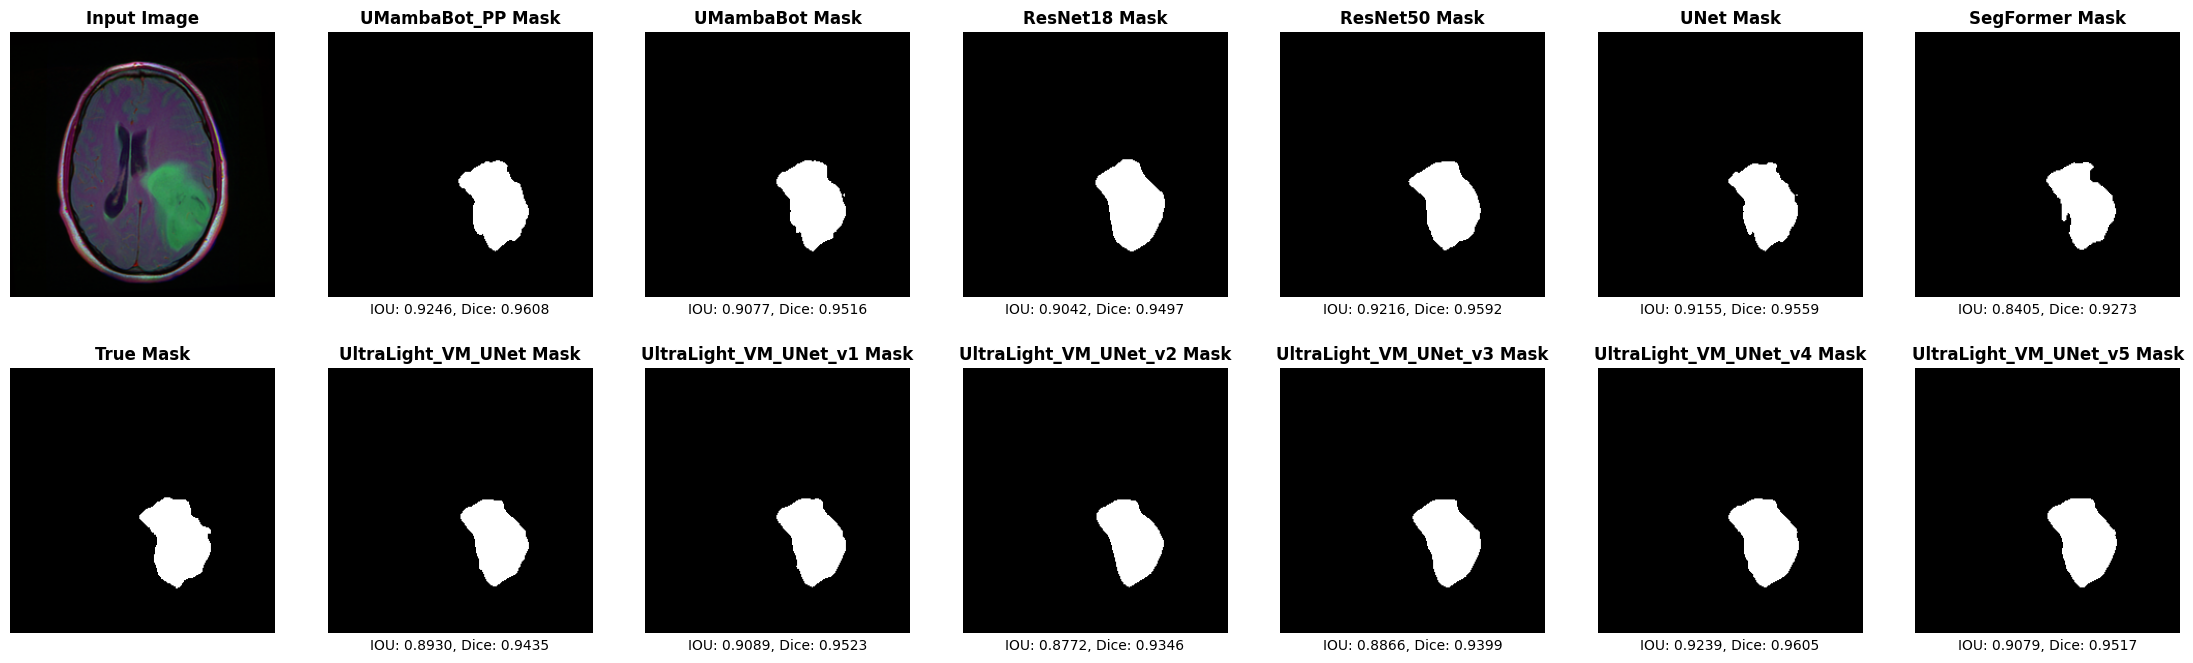

Batch 19, Image 3


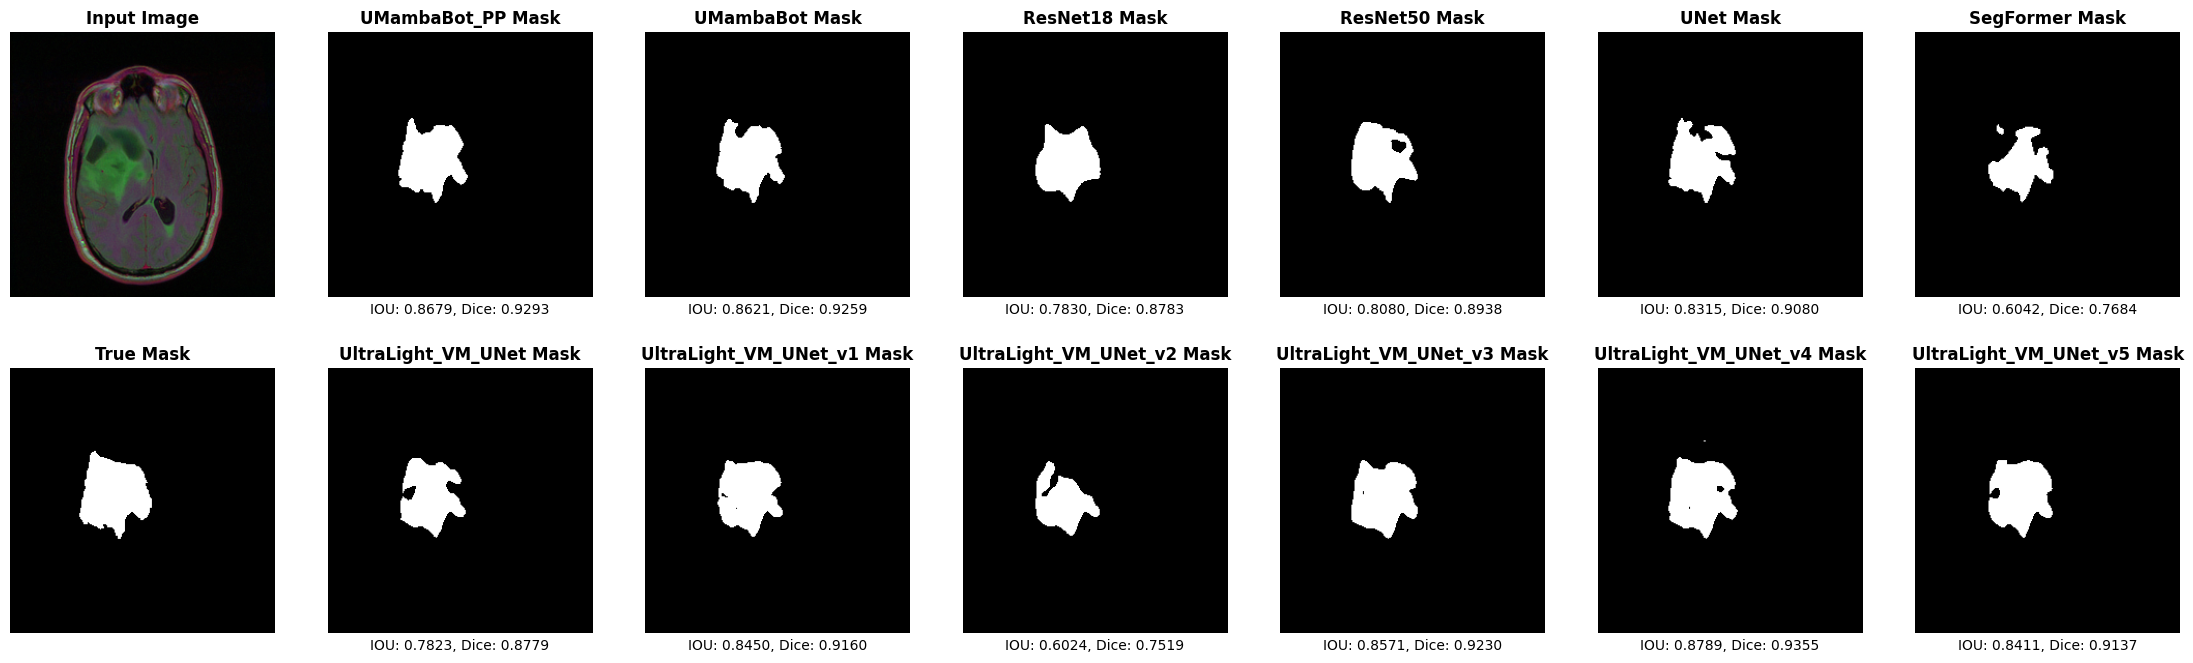

Batch 19, Image 4


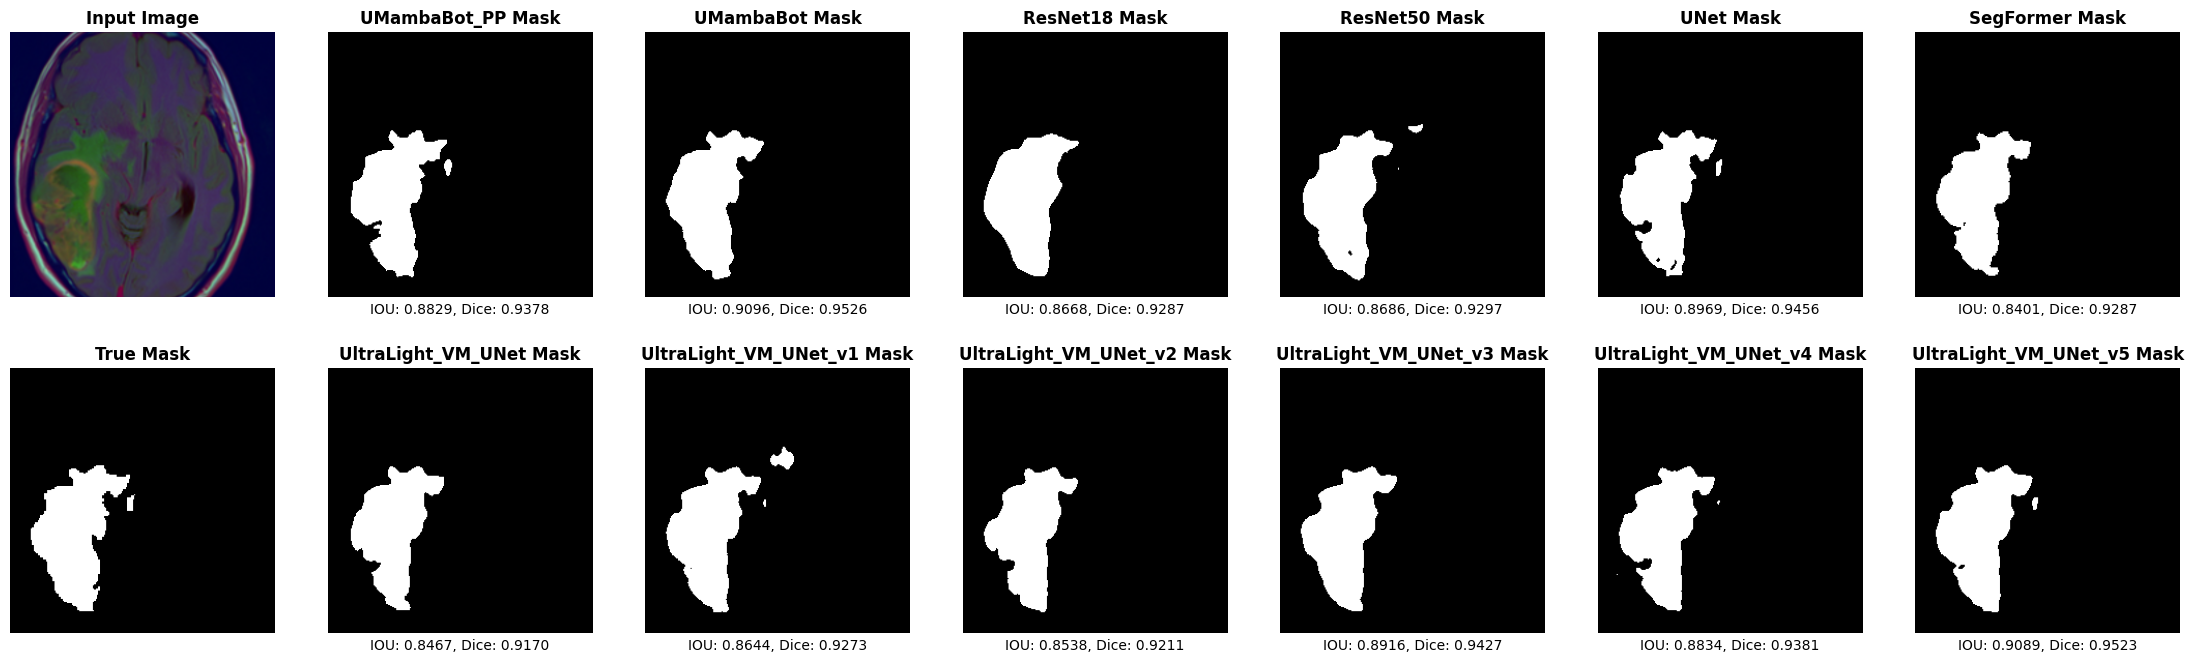

Batch 22, Image 3


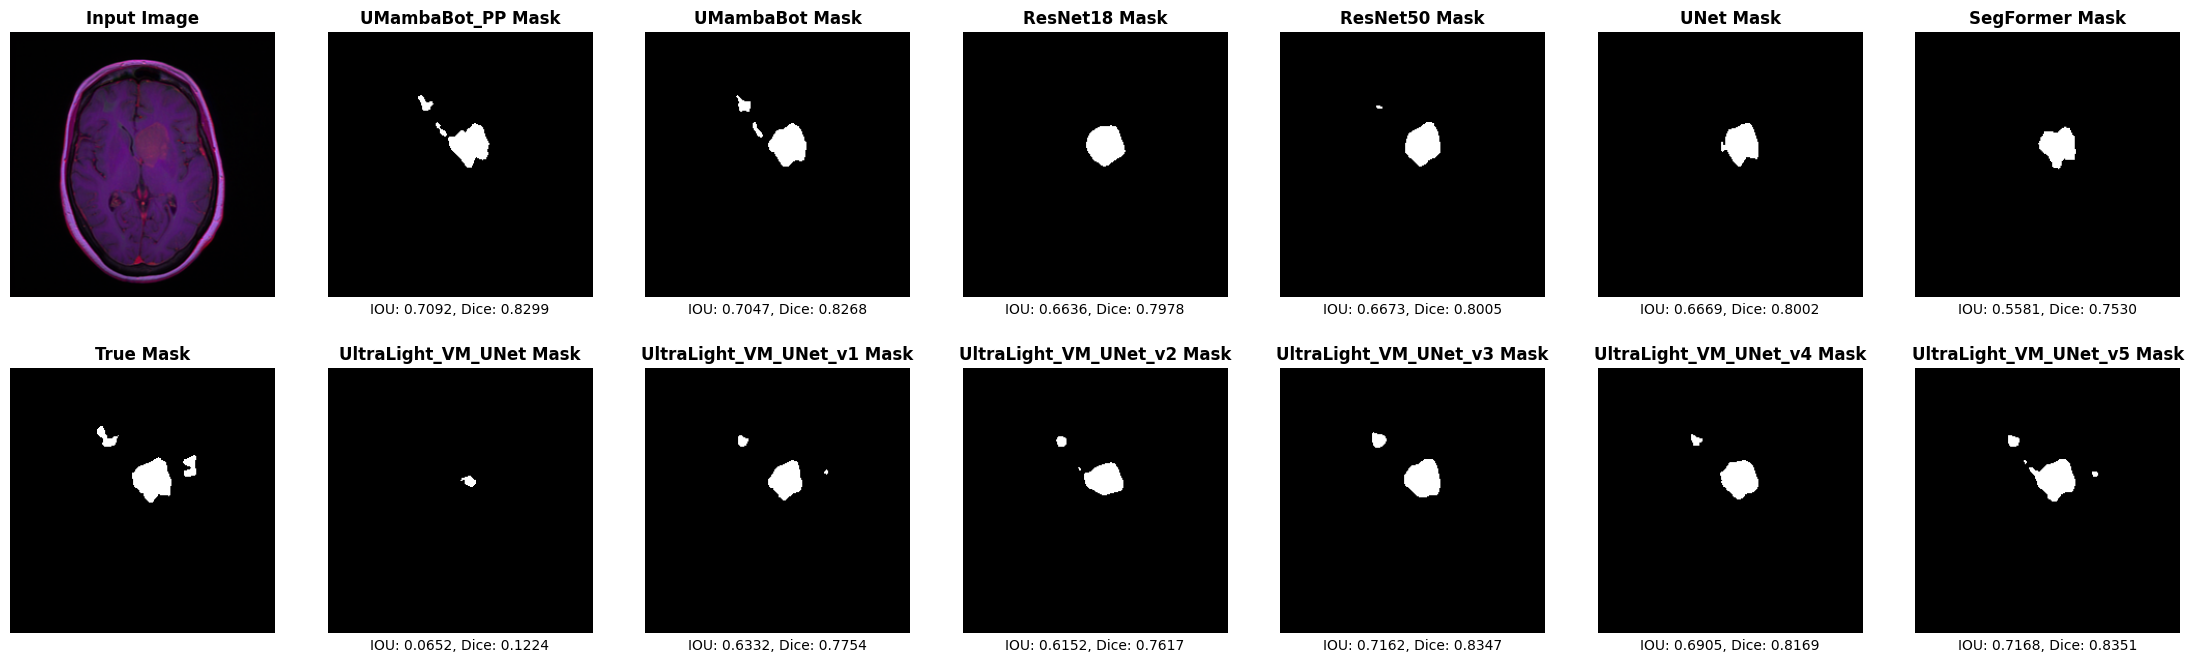

Batch 22, Image 4


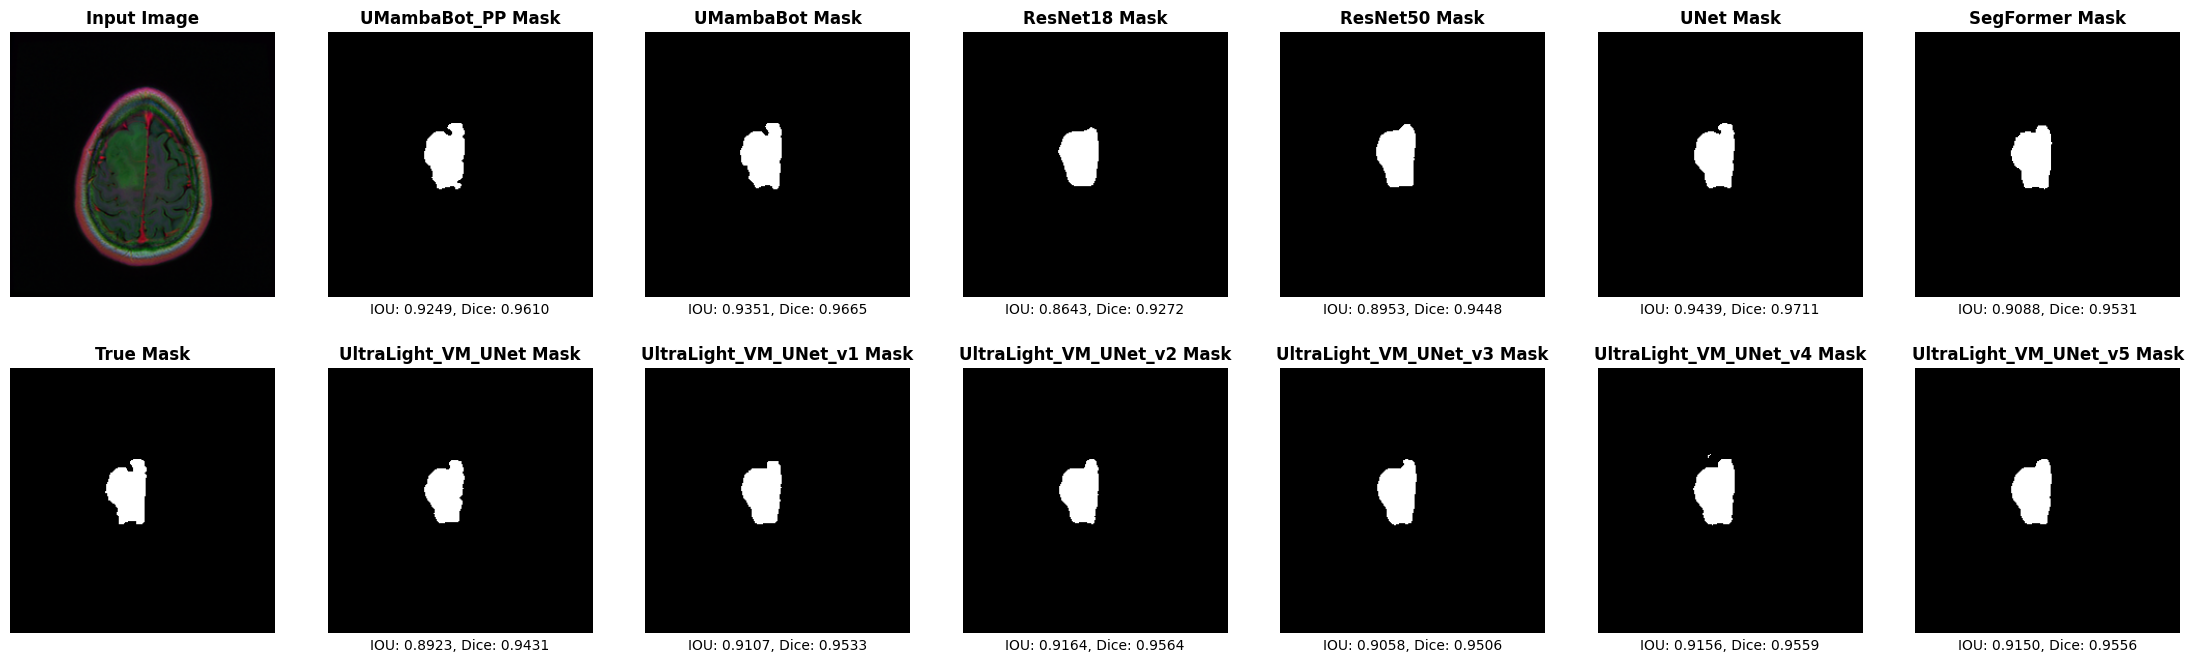

Batch 22, Image 7


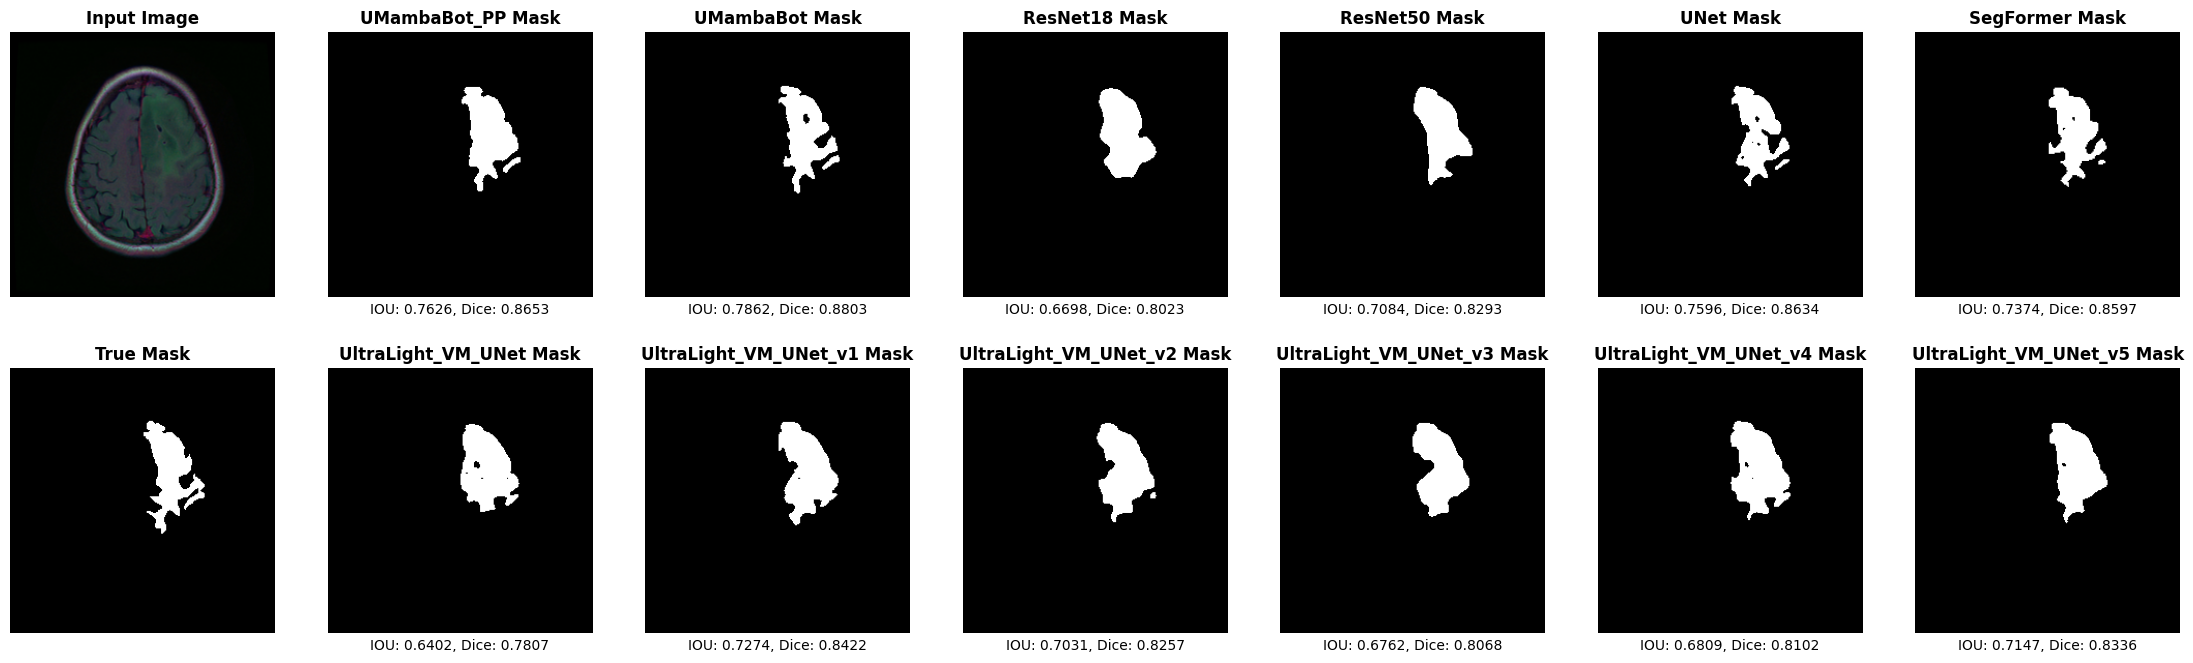

UMambaBot_PP_IOU: 0.8004537415504456
UMambaBot_PP_dice_score: 0.8867135739326477
UMambaBot_IOU: 0.7908220171928406
UMambaBot_dice_score: 0.8799108481407165
ResNet18_IOU: 0.7353594374656677
ResNet18_dice_score: 0.8432748079299927
ResNet50_IOU: 0.7281439650058746
ResNet50_dice_score: 0.8352437543869019
UNet_IOU: 0.7798599004745483
UNet_dice_score: 0.8722681617736816
SegFormer_IOU: 0.7259702968597412
SegFormer_dice_score: 0.8454124641418457
UltraLight_VM_UNet_IOU: 0.6724995994567871
UltraLight_VM_UNet_dice_score: 0.7955456972122192
UltraLight_VM_UNet_v1_IOU: 0.7358818173408508
UltraLight_VM_UNet_v1_dice_score: 0.8409071660041809
UltraLight_VM_UNet_v2_IOU: 0.7172727942466736
UltraLight_VM_UNet_v2_dice_score: 0.8303555011749267
UltraLight_VM_UNet_v3_IOU: 0.7067979073524475
UltraLight_VM_UNet_v3_dice_score: 0.810940899848938
UltraLight_VM_UNet_v4_IOU: 0.7531311798095703
UltraLight_VM_UNet_v4_dice_score: 0.8548674798011779
UltraLight_VM_UNet_v5_IOU: 0.7638152599334717
UltraLight_VM_UNet_v5_di

In [10]:

# Define the models as a list
models = [UMambaBot_pp, 
          UMambaBot, 
          ResNet18, 
          ResNet50, 
          UNet, 
          SegFormer,
          UltraLight_VM_UNet,
          UltraLight_VM_UNet_v1,
          UltraLight_VM_UNet_v2,
          UltraLight_VM_UNet_v3,
          UltraLight_VM_UNet_v4,
          UltraLight_VM_UNet_v5]

# List of titles for predicted masks
pred_mask_titles = ['UMambaBot_PP',
                    'UMambaBot',
                    'ResNet18',
                    'ResNet50',
                    'UNet', 
                    'SegFormer',
                    'UltraLight_VM_UNet',
                    'UltraLight_VM_UNet_v1',
                    'UltraLight_VM_UNet_v2',
                    'UltraLight_VM_UNet_v3',
                    'UltraLight_VM_UNet_v4',
                    'UltraLight_VM_UNet_v5']

# List of titles for images
image_titles = ['UMambaBot_PP',
                    'UMambaBot',
                    'ResNet18',
                    'ResNet50',
                    'UNet', 
                    'SegFormer',
                    'UltraLight_VM_UNet',
                    'UltraLight_VM_UNet_v1',
                    'UltraLight_VM_UNet_v2',
                    'UltraLight_VM_UNet_v3',
                    'UltraLight_VM_UNet_v4',
                    'UltraLight_VM_UNet_v5']



eval_models(models, pred_mask_titles, image_titles)


In [11]:
models = ['UMambaBot_PP',
            'UMambaBot',
            'ResNet18',
            'ResNet50',
            'SegFormer',
            'UNet',
            'ULVM_UNet', 
            'ULVM_UNet_v1', 
            'ULVM_UNet_v2', 
            'ULVM_UNet_v3',
            'ULVM_UNet_v4',
            'ULVM_UNet_v5']
params = [10076356, 9813700, 13930497, 42909633, 17782913, 7765985, 49457, 217165, 42737, 176453, 1135309, 703885]
short_params_str = ['10M', '9.8M', '13.9M', '42.9M', '17.8M', '7.8M', '0.049M', '0.20M', '0.042M', '0.176M', '1.1M', '0.7M']
short_params = [10, 9.8, 13.9, 42.9, 17.8, 7.8, 0.049, 0.20, 0.042, 0.176, 1.1, 0.7]
dice_scores = [0.8867, 0.8799, 0.8648, 0.8672, 0.8454, 0.8929, 0.79955, 0.8409, 0.8243, 0.8109, 0.8548, 0.8633]
sizes_mb = [109.15, 108.10, 55.76, 171.85, 71.13, 31.09, 0.20, 0.87, 0.17, 0.71, 4.54, 2.82] # MB
iou_scores = [0.8004, 0.7908, 0.7623, 0.7661, 0.7260, 0.8071, 0.6725, 0.7359, 0.7100, 0.7068, 0.7531, 0.7638]

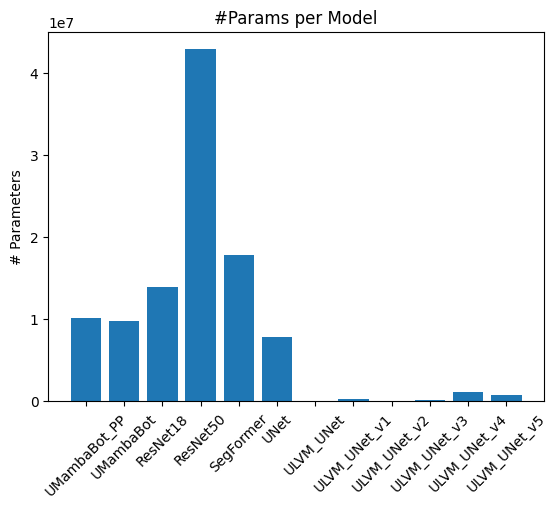

In [12]:
## Bar graphs 


# Create bar graph
plt.bar(models, params)

# Add labels and title
# plt.xlabel('Categories')
plt.ylabel('# Parameters')
plt.title('#Params per Model')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the graph
plt.show()


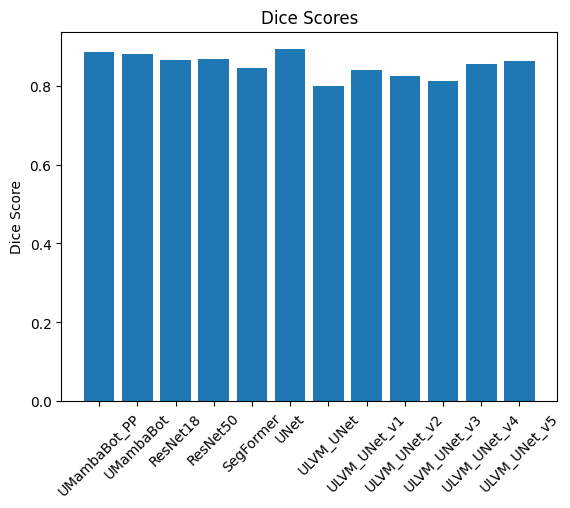

In [13]:


# Create bar graph
plt.bar(models, dice_scores)

# Add labels and title
# plt.xlabel('Categories')
plt.ylabel('Dice Score')
plt.title('Dice Scores')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the graph
plt.show()

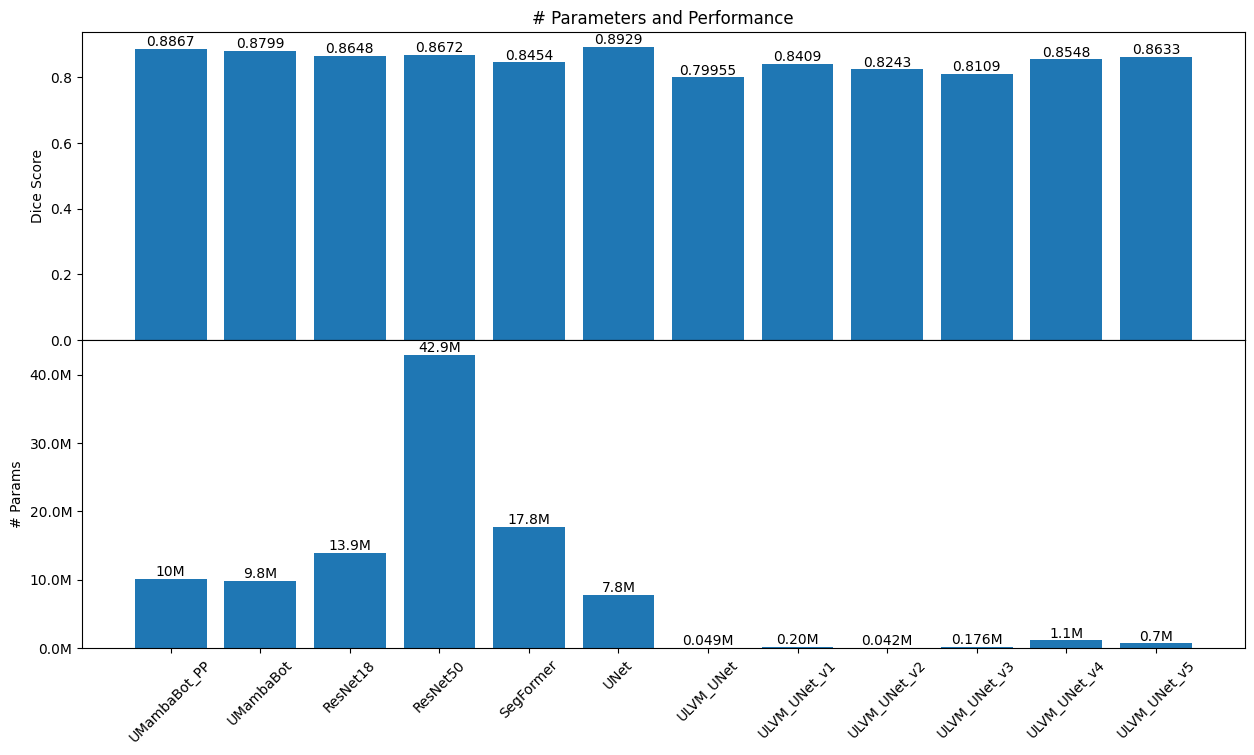

In [14]:


fig, axs = plt.subplots(2,1, figsize=(15,8))

# First subplot
bars = axs[0].bar(models, dice_scores)
axs[0].set_title('# Parameters and Performance')
axs[0].set_ylabel('Dice Score')

# Put numbers above each bar in the second subplot
for bar, param in zip(bars, dice_scores):
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, height, f'{param}', ha='center', va='bottom')

# Remove x-axis labels for the top subplot
axs[0].set_xticklabels([])

# Second subplot
bars = axs[1].bar(models, params)
axs[1].set_ylabel('# Params')

# Put numbers above each bar in the second subplot
for bar, param in zip(bars, short_params_str):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, height, f'{param}', ha='center', va='bottom')


# Rotate x-axis labels
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

# Scale y-axis ticks in millions
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M')
axs[1].yaxis.set_major_formatter(formatter)

# Adjust layout to make bottom of first plot touch the top of the second plot
plt.subplots_adjust(hspace=0)

# Show the plots
plt.show()

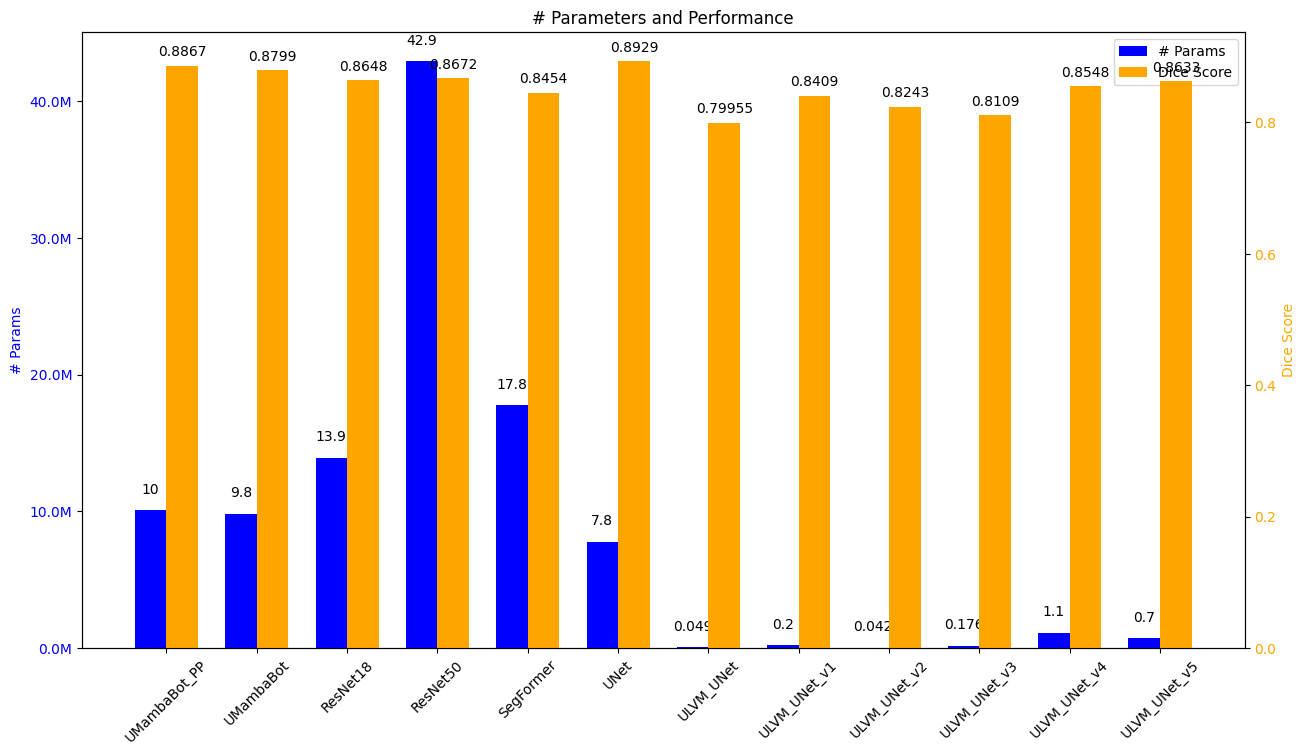

In [15]:



# Position for each category
x = np.arange(len(models))

# Width of each bar
width = 0.35

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_title('# Parameters and Performance')

# Plot bars for parameters
bars1 = ax1.bar(x - width/2, params, width, label='# Params', color='blue')

# Set primary y-axis label and ticks
ax1.set_ylabel('# Params', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot bars for dice scores
bars2 = ax2.bar(x + width/2, dice_scores, width, label='Dice Score', color='orange')

# Set secondary y-axis label and ticks
ax2.set_ylabel('Dice Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set x-axis labels and ticks
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)

# Put numbers above each bar for parameters
for i, short_param in enumerate(short_params):
    ax1.text(x[i] - width/2, params[i] + 1000000, f'{short_param}', ha='center', va='bottom')

# Put numbers above each bar for dice scores
for i, score in enumerate(dice_scores):
    ax2.text(x[i] + width/2, score + 0.01, f'{score}', ha='center', va='bottom')

# Set legend with correct colors
handles, labels = [], []
handles.append(bars1[0])
handles.append(bars2[0])
labels.append('# Params')
labels.append('Dice Score')
ax1.legend(handles, labels, loc='upper right')

# Scale y-axis ticks for parameters in millions
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M')
ax1.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

In [9]:
import glob
### Get distributions of data

ct = 0

train_tumors = 0
train_no_tumors = 0

val_tumors = 0
val_no_tumors = 0

test_tumors = 0
test_no_tumors = 0

for imgs, masks in train_dataloader:
    for mask in masks:
        if (torch.sum(mask == 1).item() > 0):
            train_tumors += 1
        else:
            train_no_tumors += 1

for imgs, masks in val_dataloader:
    for mask in masks:
        if (torch.sum(mask == 1).item() > 0):
            val_tumors += 1
        else:
            val_no_tumors += 1

for imgs, masks in test_dataloader:
    for mask in masks:
        if (torch.sum(mask == 1).item() > 0):
            test_tumors += 1
        else:
            test_no_tumors += 1
    
print(f'Train dataset: Images with tumor: {train_tumors}, No tumor: {train_no_tumors}')
print(f'Val dataset: Images with tumor: {val_tumors}, No tumor: {val_no_tumors}')
print(f'Test dataset: Images with tumor: {test_tumors}, No tumor: {test_no_tumors}')



Train dataset: Images with tumor: 1103, No tumor: 2040
Val dataset: Images with tumor: 133, No tumor: 260
Test dataset: Images with tumor: 137, No tumor: 256


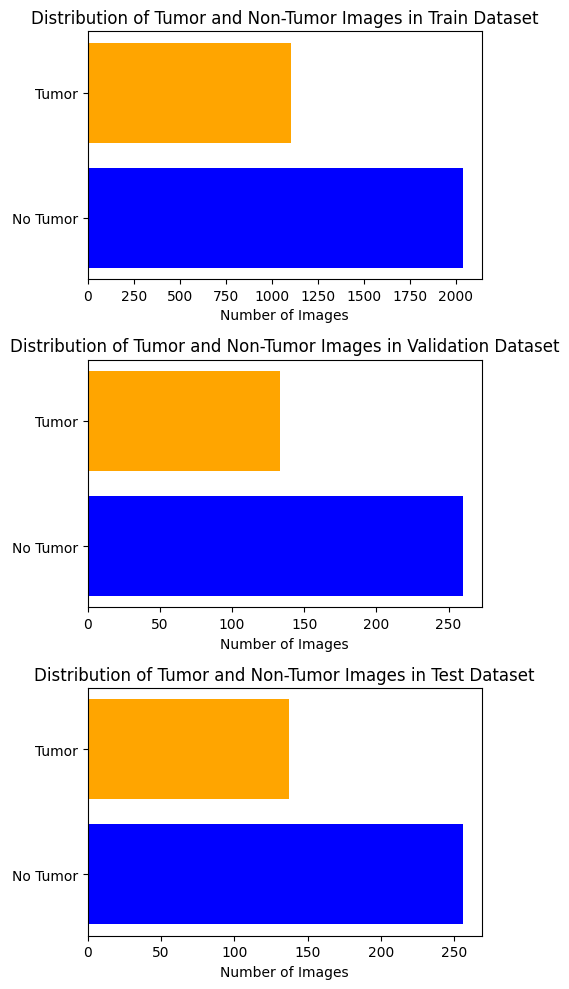

In [11]:
# Define data
categories = ['No Tumor', 'Tumor']
train_counts = [2040, 1103]
val_counts = [260, 133]
test_counts = [256, 137]

# Create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# Plot tumor and non-tumor counts for the train dataset
axs[0].barh(categories, train_counts, color=['blue', 'orange'])
axs[0].set_title('Distribution of Tumor and Non-Tumor Images in Train Dataset')
axs[0].set_xlabel('Number of Images')

# Plot tumor and non-tumor counts for the validation dataset
axs[1].barh(categories, val_counts, color=['blue', 'orange'])
axs[1].set_title('Distribution of Tumor and Non-Tumor Images in Validation Dataset')
axs[1].set_xlabel('Number of Images')

# Plot tumor and non-tumor counts for the test dataset
axs[2].barh(categories, test_counts, color=['blue', 'orange'])
axs[2].set_title('Distribution of Tumor and Non-Tumor Images in Test Dataset')
axs[2].set_xlabel('Number of Images')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [40]:
# Extract patient IDs from paths
train_df['patient_id'] = train_df['images_paths'].apply(lambda x: x.split('/')[0])

# Count occurrences of each patient ID
patient_image_counts = train_df['patient_id'].value_counts()

print("Number of images for each patient ID:")
print(patient_image_counts)

Number of images for each patient ID:
patient_id
..    3143
Name: count, dtype: int64


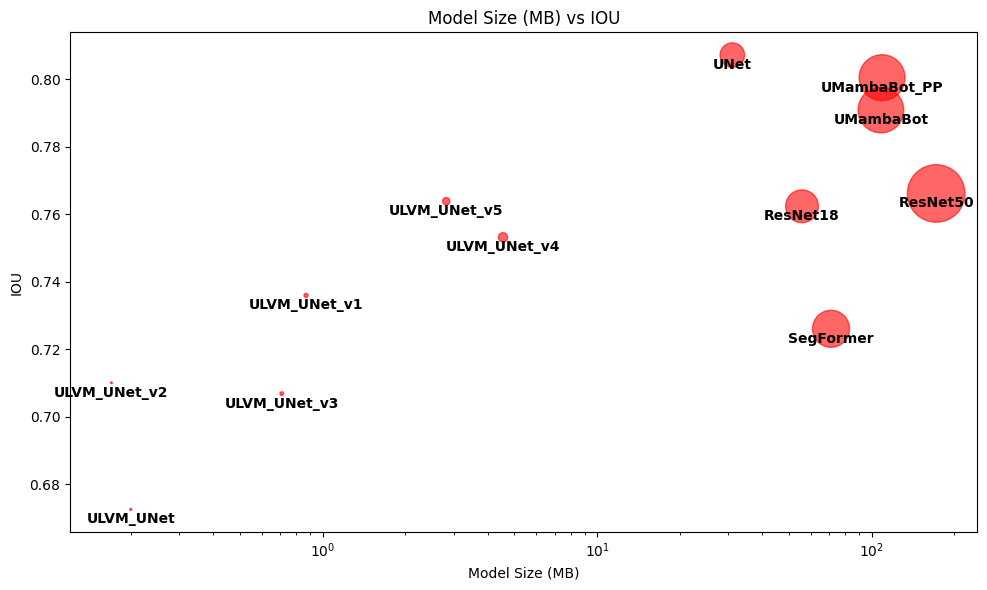

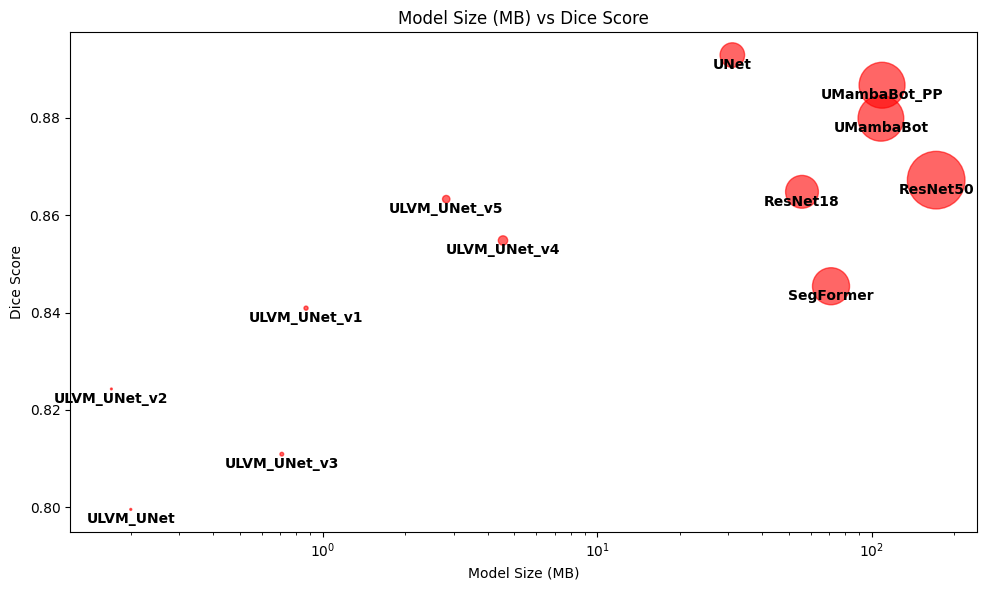

In [17]:


# Size (MB) vs IOU
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(sizes_mb, iou_scores, s=[s*10 for s in sizes_mb], alpha=0.6, color='red')
ax.set_xscale("log")
ax.set_xlabel("Model Size (MB)")
ax.set_ylabel("IOU")
ax.set_title("Model Size (MB) vs IOU")
for i, name in enumerate(models):
    ax.annotate(name, (sizes_mb[i], iou_scores[i]), xytext=(0, -10), textcoords='offset points', ha='center',fontweight='bold')
plt.tight_layout()
plt.show()

# Size (MB)
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(sizes_mb, dice_scores, s=[s*10 for s in sizes_mb], alpha=0.6, color='red')
ax.set_xscale("log")
ax.set_xlabel("Model Size (MB)")
ax.set_ylabel("Dice Score")
ax.set_title("Model Size (MB) vs Dice Score")
for i, name in enumerate(models):
    ax.annotate(name, (sizes_mb[i], dice_scores[i]), xytext=(0, -10), textcoords='offset points', ha='center',fontweight='bold')
plt.tight_layout()
plt.show()


Batch 23, Img 15


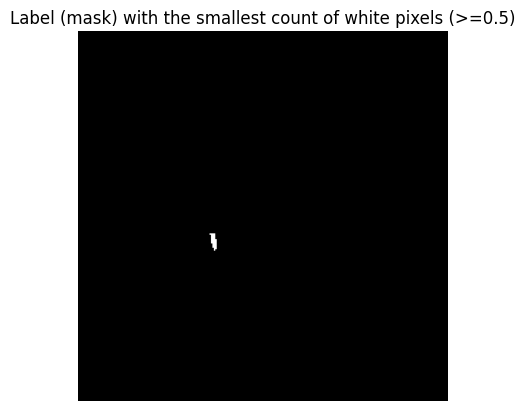

UMambaBot_PP_IOU: 0.8004537415504456
UMambaBot_PP_dice_score: 0.8867135739326477
UMambaBot_IOU: 0.7908220171928406
UMambaBot_dice_score: 0.8799108481407165
ResNet18_IOU: 0.7353594374656677
ResNet18_dice_score: 0.8432748079299927
ResNet50_IOU: 0.7281439650058746
ResNet50_dice_score: 0.8352437543869019
UNet_IOU: 0.7798599004745483
UNet_dice_score: 0.8722681617736816
UltraLight_VM_UNet_v1_IOU: 0.7358818173408508
UltraLight_VM_UNet_v1_dice_score: 0.8409071660041809
SegFormer_IOU: 0.7259702968597412
SegFormer_dice_score: 0.8454124641418457


In [42]:
# # Initialize variables to keep track of the smallest count and its corresponding batch and image numbers
# smallest_count = float('inf')
# smallest_batch_num = -1
# smallest_image_num = -1

# # Iterate through each batch in the test_dataloader
# for batch_num, (imgs, labels) in enumerate(test_dataloader):
#     imgs, labels = imgs.to(device).float(), labels.to(device).float()

#     # Iterate through each image in the batch
#     for image_num, label in enumerate(labels):
#         # Count the number of white pixels (>=0.5) in the label
#         white_pixel_count = torch.sum(label == 1.).item()

#         # Check if this count is smaller than the smallest count found so far
#         if white_pixel_count > 0 and white_pixel_count < smallest_count:
#             smallest_count = white_pixel_count
#             smallest_batch_num = batch_num
#             smallest_image_num = image_num

#             # Plot the label (mask) with the smallest count
#             smallest_label = label
# print(f'Batch {smallest_batch_num}, Img {smallest_image_num}')            
# plt.imshow(smallest_label.squeeze().cpu().numpy(), cmap='gray')
# plt.axis('off')
# plt.title("Label (mask) with the smallest count of white pixels (>=0.5)")
# plt.show()


# # Define the models as a list
# models = [UMambaBot_pp, 
#           UMambaBot, 
#           ResNet18, 
#           ResNet50, 
#           UNet, 
#           UltraLight_VM_UNet_v1,
#           SegFormer]
# # List of titles for predicted masks
# pred_mask_titles = ['UMambaBot_PP',
#                     'UMambaBot',
#                     'ResNet18',
#                     'ResNet50',
#                     'UNet', 
#                     'UltraLight_VM_UNet_v1',
#                     'SegFormer']
# # List of titles for images
# image_titles = ['Input Image', 
#                 'UMambaBot_PP',
#                 'UMambaBot',
#                 'ResNet18',
#                 'ResNet50',
#                 'UNet',
#                 'UltraLight_VM_UNet_v1',
#                 'SegFormer']

# # # Iterate through test_dataloader until you reach the desired batch index
# # for idx, (imgs, labels) in enumerate(test_dataloader):
# #     if idx == smallest_batch_num:
# #         t_image = imgs[smallest_image_num]
# #         t_label = labels[smallest_image_num]


# # Initialize lists to store total IOU and Dice scores for each model
# num_models = len(models)
# total_iou = [0] * num_models
# total_dice_score = [0] * num_models

# ct = 0


# with torch.no_grad():
#     for (imgs, labels), (sf_imgs, sf_labels) in zip(test_dataloader, segformer_test_dataloader):
#         imgs, labels = imgs.to(device).float(), labels.to(device).float()
#         sf_imgs, sf_labels = sf_imgs.to(device).float(), sf_labels.to(device).float()

#         # Make predictions for each model
#         preds = []
#         for model in models:
#             if (model == SegFormer):
#                 # Segformer model predictions
#                 pred = SegFormer(sf_imgs)
#                 pred = nn.functional.interpolate(pred, size=sf_labels.shape[-2:], mode="bilinear", align_corners=False)
#                 pred = (torch.sigmoid(pred) >= 0.5).to(torch.float32)
#                 preds.append(pred)
#             else:    
#                 pred = model(imgs)
#                 pred = torch.where(pred >= 0.5, 1., 0.)
#                 preds.append(pred)
            
#         # Visualize the sample and calculate IOU and Dice scores for the first batch
#         if ct <= len(test_dataloader):
#             for k in range(len(preds)):
                
#                 display_imgs = False
#                 if ct == smallest_batch_num and k == smallest_image_num:
#                     display_imgs = True


#                 if display_imgs:
#                     print(f'Batch {ct}, Image {k}')

#                     v_preds = []
#                     for i in range(len(preds)):
#                         v_preds.append(preds[i][k])

#                     v_iou = []
#                     v_dice = []
#                     for i in range(num_models):
#                         if (models[i] == SegFormer):
#                             iou = calculate_iou(preds[i][k], sf_labels[k])
#                             dice_score = calculate_dice_score(preds[i][k], sf_labels[k])
#                             v_iou.append(iou)
#                             v_dice.append(dice_score)
#                         else:
#                             iou = calculate_iou(preds[i][k], labels[k])
#                             dice_score = calculate_dice_score(preds[i][k], labels[k])
#                             v_iou.append(iou)
#                             v_dice.append(dice_score)

#                     visualize_sample(imgs[k], labels[k], v_preds, image_titles, pred_mask_titles, v_iou, v_dice)

#         ct += 1

#         # Calculate total IOU and Dice scores for each model
#         for i in range(num_models):
#             if (models[i] == SegFormer):
#                 total_iou[i] += calculate_iou(preds[i], sf_labels)
#                 total_dice_score[i] += calculate_dice_score(preds[i], sf_labels)
#             else: 
#                 total_iou[i] += calculate_iou(preds[i], labels)
#                 total_dice_score[i] += calculate_dice_score(preds[i], labels)

# # Calculate average IOU and Dice scores for each model
# test_iou = [iou / len(test_dataloader) for iou in total_iou]
# test_dice_score = [dice / len(test_dataloader) for dice in total_dice_score]

# # Print average IOU and Dice scores for each model
# for i in range(num_models):
#     print(f'{pred_mask_titles[i]}_IOU: {test_iou[i]}')
#     print(f'{pred_mask_titles[i]}_dice_score: {test_dice_score[i]}')

